<a href="https://colab.research.google.com/github/J1116/physics/blob/main/Chapter4_revised0315.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4章 カーネル関数による類似度評価

## importするライブラリ

今回使うライブラリを最初にまとめておきます。ライブラリがimportされていない旨のerrorが起きた場合はこの後のセルを実行してください。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.kernel_ridge import KernelRidge
import scipy as sp
from scipy import stats as st

また、また、2章で計算した「著者当てゲーム」の単語の出現頻度を記録したファイルを読み込みます。

In [ ]:
from google.colab import drive
drive.mount('./temp')

Mounted at ./temp


In [ ]:
cd ./temp/My\ Drive/MLTextBook

/content/temp/My Drive/MLTextBook


In [ ]:
import pickle
with open('hgram.txt', 'rb') as f:
    hgram = pickle.load(f)
union = set()
for d in hgram:
    union |= d.keys()
def count(dict, word):
    if word in dict:
        return dict[word]
    else:
        return 0
raw_vector = np.array([[count(d, w) for w in union] for d in hgram])

以下のセルを実行して、芥川龍之介の「羅生門」に現れる単語のヒストグラムが表示されれば、正しくデータが読み込まれました。

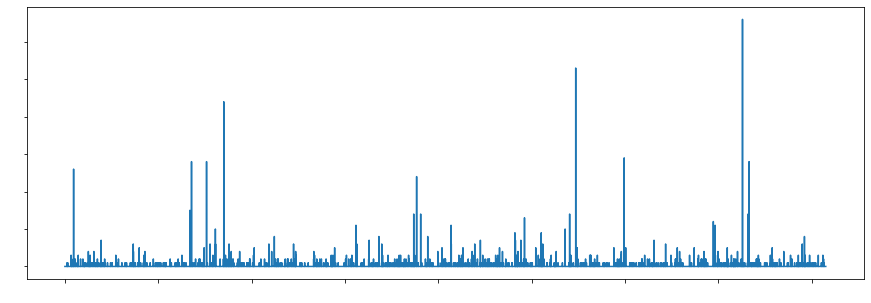

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(union)), raw_vector[0])
plt.xticks(color='None')
plt.yticks(color='None')
plt.show()

# 4章　カーネル関数による類似度評価

2章と3章では、（疑似）距離を類似度関数として利用して、著者当てゲームに取り組みました。

距離関数も疑似距離関数も、データの間の類似性が高ければ、関数の値が小さくなるという性質をもちます。
一方、類似性が高ければ関数の値が大きくなる類似度関数として、カーネル関数が広く使われています。

4章では、カーネル関数を類似度関数として利用するカーネルマシンとカーネル関数の組み合わせによる機械学習の手法を見ていきます。

カーネルマシンの代表例であり、最も広く利用されている機械学習アルゴリズムの一つである「サポートベクターマシン」を利用して、著者当てゲームの再チャレンジします。

## 4.1 カーネル関数

カーネル関数は、以下に述べる「正定値性」と呼ばれる性質を満足する二変数関数として定義されます。

>   任意のデータ$x$をベクトル$\vec v(x) = (v_1(x), \dots, v_n(x))$で表現する関数$\vec v(\cdot)$を適切に定めることで、
> 
> $$k(x, y) = v_1(x)\cdot v_1(y) + \dots + v_n(x)\cdot v_n(y)$$
> 
> が成り立つ。
>$\vec v(x)$をデータ$x$の**特徴ベクトル**とよび、式の右辺は$x$の特徴ベクトルと$y$の特徴ベクトルの内積である。

数学的に詳しい説明は本書にゆずるものとして、具体的な例を通してカーネル関数を見ていきます。

### 4.1.1 線形カーネル

まず最も簡単なカーネル関数として線形カーネルを考えましょう。

線形カーネルは、データ$x$が$(v_1(x), \dots, v_n(x))$とベクトルとして明示的に与えられている場合に、以下のように定義されます。

$$
L(x,y) = v_1(x)v_1(y) + \cdots + v_n(x)v_n(y)
$$

以下のようにプロットされる2次元のデータを20個生成します。

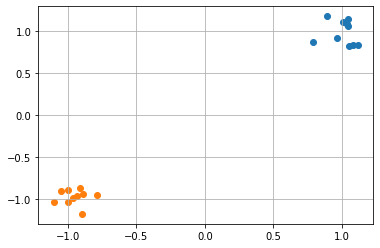

In [ ]:
n = 10
xp = np.random.normal(loc=1, scale=0.1, size=10)
yp = np.random.normal(loc=1, scale=0.1, size=10)
xn = np.random.normal(loc=-1, scale=0.1, size=10)
yn = np.random.normal(loc=-1, scale=0.1, size=10)
plt.scatter(xp, yp)
plt.scatter(xn, yn)
plt.grid()
plt.show()

点$(1，1)$の周辺に集まる10個のデータと、点$(-1, -1)$の周辺にあつまる10個のデータからなりますが、この順番に順番に$x_1$から$x_{20}$まで番号をつけて呼びましょう。

- $x_1, \dots, x_{10}$は$(1, 1)$の周辺
- $x_{10}, \dots, x_{20}$は$(-1, -1)$の周辺

次の20行20列の行列を**グラム行列**と呼びます。

$$
\begin{bmatrix}
L(x_1, x_1) & L(x_1, x_2) & \dots & L(x_1, x_{20})\\
L(x_2, x_1) & L(x_2, x_2) & \dots & L(x_2, x_{20})\\
\vdots & \vdots & \ddots & \vdots\\
L(x_{20}, x_1) & L(x_{20}, x_2) & \dots & L(x_{20}, x_{20})\\
\end{bmatrix}
$$

上記のデータについて、グラム行列を計算してみます。

In [ ]:
import numpy as np
def linear_kernel(V):
  G = np.dot(V, V.T)
  return G

In [ ]:
V = np.array([[xp[i], yp[i]] if i < n else [xn[i - n], yn[i - n]] for i in range(2*n)])
G = linear_kernel(V)
for r in G:
  print(" ".join([str(round(x, 2)) for x in r]))


1.76 1.98 1.99 1.84 1.8 1.97 2.05 1.93 1.56 1.76 -2.0 -1.9 -1.78 -1.84 -1.78 -1.63 -1.68 -1.83 -1.94 -1.71
1.98 2.23 2.24 2.05 2.01 2.21 2.31 2.19 1.76 1.96 -2.25 -2.14 -2.0 -2.05 -1.99 -1.85 -1.88 -2.06 -2.2 -1.93
1.99 2.24 2.26 2.07 2.03 2.23 2.33 2.2 1.77 1.98 -2.27 -2.16 -2.02 -2.07 -2.01 -1.86 -1.9 -2.08 -2.21 -1.94
1.84 2.05 2.07 1.95 1.91 2.05 2.12 1.98 1.61 1.86 -2.1 -1.98 -1.85 -1.93 -1.87 -1.68 -1.75 -1.91 -1.99 -1.78
1.8 2.01 2.03 1.91 1.87 2.01 2.08 1.94 1.58 1.82 -2.05 -1.94 -1.82 -1.89 -1.83 -1.65 -1.71 -1.87 -1.95 -1.74
1.97 2.21 2.23 2.05 2.01 2.2 2.3 2.17 1.75 1.96 -2.24 -2.13 -1.99 -2.05 -1.99 -1.83 -1.87 -2.05 -2.18 -1.92
2.05 2.31 2.33 2.12 2.08 2.3 2.4 2.27 1.82 2.03 -2.33 -2.22 -2.08 -2.13 -2.07 -1.92 -1.95 -2.14 -2.28 -2.0
1.93 2.19 2.2 1.98 1.94 2.17 2.27 2.17 1.73 1.89 -2.19 -2.1 -1.96 -2.0 -1.94 -1.83 -1.84 -2.02 -2.18 -1.89
1.56 1.76 1.77 1.61 1.58 1.75 1.82 1.73 1.39 1.54 -1.77 -1.69 -1.58 -1.62 -1.57 -1.46 -1.48 -1.62 -1.74 -1.52
1.76 1.96 1.98 1.86 1.82 1.

$20\times 20 = 400$の数字が並んでいることが分かります。

数字だとわかりにくいので、数値の大きさを色で表して、$20\times 20$マスのグラフ（ヒートマップ）で表します。

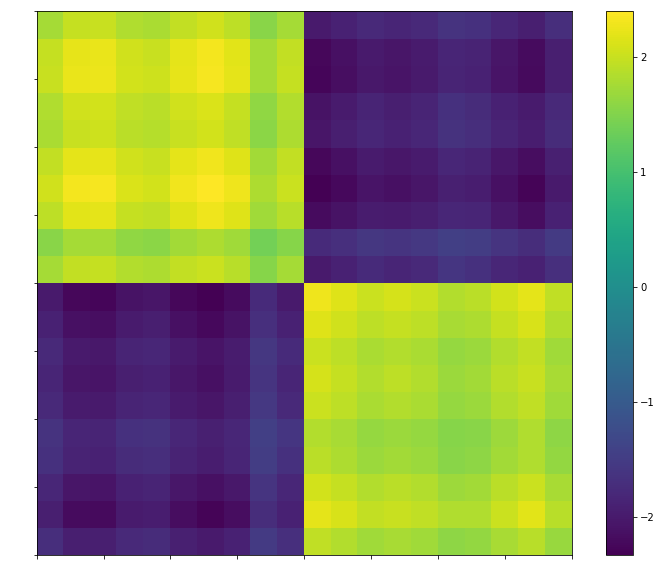

In [ ]:
plt.figure(figsize=(12, 10))
plt.pcolor(np.flipud(G))
plt.xticks(color='None')
plt.yticks(color='None')
plt.colorbar()
plt.show()

グラフから次の様子が分かると思います。

- 互いに近い$x_1, \dots, x_{10}$の間のカーネル$L(x_i, x_j)$の値は大きく、
従って、行列の左上4分の1は明るい色で表示されています。
- 互いに近い$x_{11}, \dots, x_{20}$の間のカーネル$L(x_i, x_j)$の値は大きく、
従って、行列の右下4分の1は明るい色で表示されています。
- 行列のその他の成分は互いに離れた点の間のカーネルの値であるので、行列の右上4分の1と行列の左下4分の1は暗い色で表示されています。

このように、2点が近ければカーネルの値が大きくなり、遠ければカーネルの値が小さくなることが、
線形カーネルに限らず、カーネル関数共通の重要な性質です。

上記の例では、データは二つのグループに明確に分離していたことから、グラム行列の成分の値も明確に4分割されました。

次の例では、データをもう少しばらつかせて見ます。

以降の説明でもこのデータを利用しますので、便宜上、今後は今後は**人口データセット人工データセット**と呼ぶことにします。

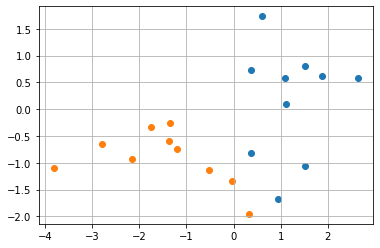

In [ ]:
n = 10
xp = np.random.normal(loc=1, size=10)
yp = np.random.normal(loc=1, size=10)
xn = np.random.normal(loc=-1, size=10)
yn = np.random.normal(loc=-1, size=10)
plt.scatter(xp, yp)
plt.scatter(xn, yn)
plt.grid()
plt.show()

人工データセットに対するグラム行列をヒートマップで表して見ます。

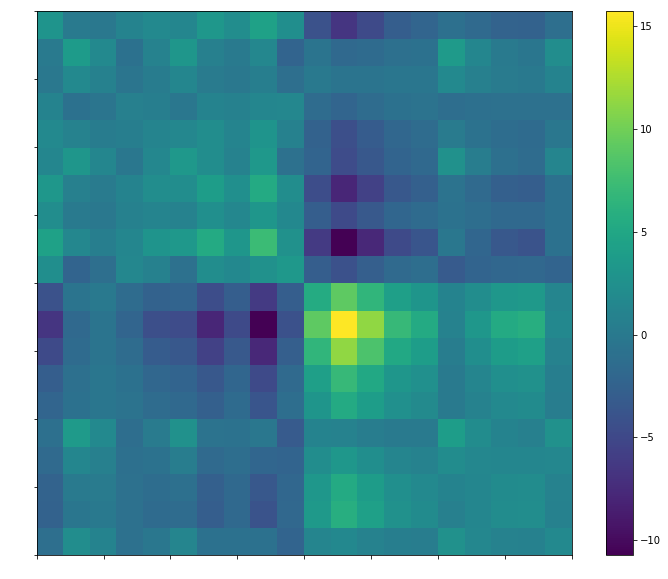

In [ ]:
V = np.array([[xp[i], yp[i]] if i < n else [xn[i - n], yn[i - n]] for i in range(2*n)])
G = linear_kernel(V)
plt.figure(figsize=(12, 10))
plt.pcolor(np.flipud(G))
plt.xticks(color='None')
plt.yticks(color='None')
plt.colorbar()
plt.show()

前回の例とは違って、正例と負例が明確に分離していないことから、色の分離は多少曖昧になってしまったことに気がつくと思います。
それでも、左上の部分行列と右下の部分行列が明るく表示されています。

このことは、
カーネルの値による正例と負例の境界が前の例に比較すると不明瞭になり、
線形カーネルに基づいて分類問題を解くことが困難になったことを示唆しています。

この後ではカーネル関数を、線形カーネルから別の関数に変更していくことで、カーネル値の分離が改善されていくことを見ていきます。

その前に、著者当てゲームのデータについて、同じように線形カーネルによるグラム行列をヒートマップで表示してみましょう。

In [ ]:
lk_matrix = np.array([[np.inner(x, y) for y in raw_vector] for x in raw_vector])

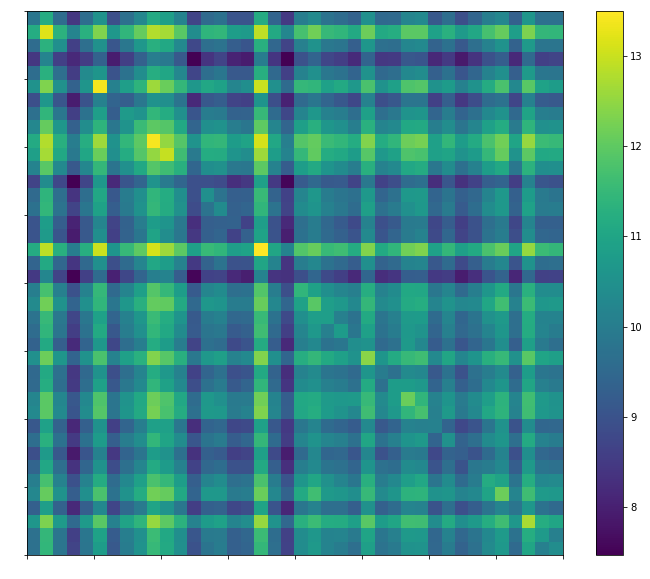

In [ ]:
lk_matrix = linear_kernel(raw_vector)
plt.figure(figsize=(12, 10))
plt.pcolor(np.flipud(np.log(lk_matrix)))
plt.colorbar()
plt.xticks(color='None')
plt.yticks(color='None')
plt.show()

作品間での線形カーネルの値の差が大きいので、対数値でプロットしてみました。

線形カーネルの値が芥川の作品と菊池の作品を明確に判別することができるのであれば、
サイズが$20\times 20$の左上の部分行列と、同じサイズの右下の部分行列が明るく表示されるはずなのですが、
少なくとも目視ではそのような区別は見いだせません。
線形カーネルでは、芥川の作品と菊池の作品を区別することが難しいことを暗に示唆しています。

### 4.1.2 コサイン類似度

次にコサイン類似度について考えましょう。コサイン類似度の定義は以下のようになります。

$$
C(x,y) = \left( \frac{\vec{v}(x)}{\|\vec{v}(x)\|} \right) \cdot \left( \frac{\vec{v}(y)}{\|\vec{v}(y)\|} \right)
$$

線形カーネルをコサイン類似度に置き換えて、同じようにグラム行列を計算します。

まず、人工データセットのグラム行列を計算しましょう。

In [ ]:
def cos_kernel(V):
  V_nor = np.diag(1 / np.linalg.norm(V, ord = 2, axis = 1))
  V_new = np.dot(V_nor, V)
  G = np.dot(V_new, V_new.T)
  return G

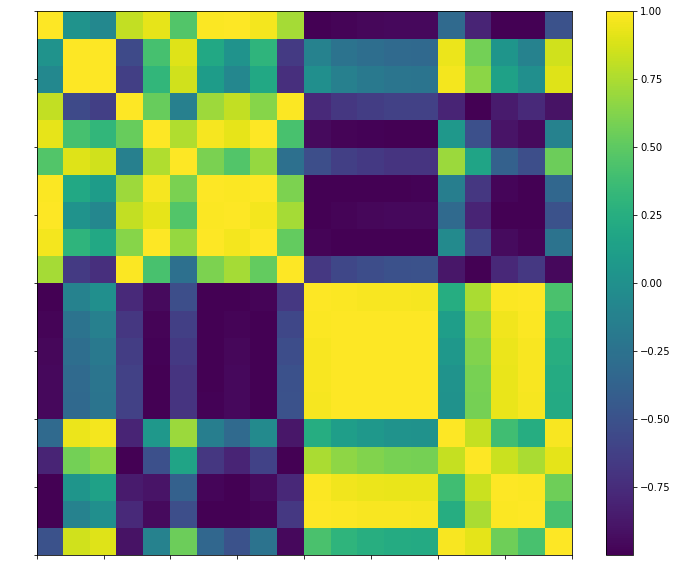

In [ ]:
G = cos_kernel(V)
plt.figure(figsize=(12, 10))
plt.pcolor(np.flipud(G))
plt.xticks(color='None')
plt.yticks(color='None')
plt.colorbar()
plt.show()

曖昧だったカーネル値（類似度）の区別が明確になり、
左上の部分行列と右下の部分行列が明確に色分けされました。されました。

分類問題を解くときには、線形カーネルよりコサイン類似度を利用した方が良いであろうことがうかがえます。

同様に、著者当てゲームのデータで、グラム行列を計算します。

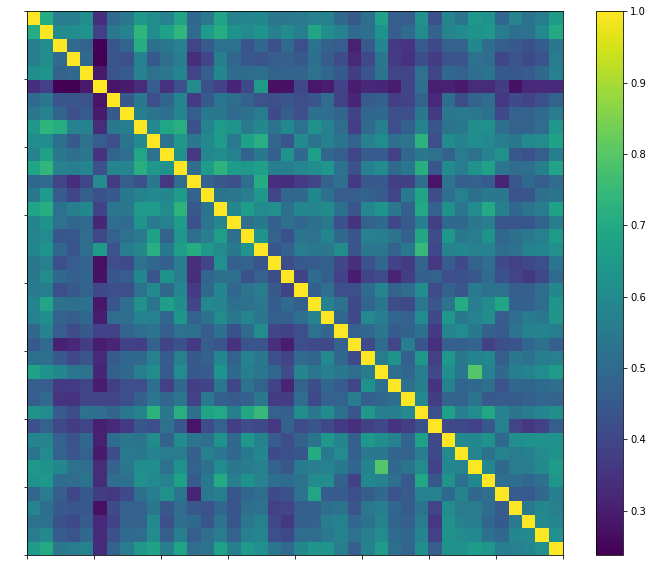

In [ ]:
cos_matrix = cos_kernel(raw_vector)
plt.figure(figsize=(12, 10))
plt.pcolor(np.flipud(cos_matrix))
plt.xticks(color='None')
plt.yticks(color='None')
plt.colorbar()
plt.show()

コサイン類似度がとる値の範囲は範囲は$-1$からから$1$であり、また、対角線の値は常に1なので、
対角線上のマス目は明るい色で表示されています。表示されています。
一方でその他のマス目は、少なくとも目視では、同じように色づけされているように見えます。

著者当てゲームでは、線形カーネルをコサイン類似度に変更しても、
分類問題はうまく解くことができない可能性を示唆しています。

### 4.1.3 多項式カーネル
次に多項式カーネルについて考えましょう。
$L(x,y)$を線形カーネルとしたとき、多項式カーネルの定義は以下のようになります。

$$
f(X) = a_d X^d + a_{d-1} X^{d-1} + \cdots + a_1 X +a_0, \quad
a_1 \ge 0, \dots, a_{d-1} \ge 0, a_d > 0
$$

について

$$
L_f(x,y) = a_d L(x,y)^d + a_{d-1}L(x,y)^{d-1} + \cdots + a_1L(x,y) +a_0
$$

実用では、次の形の多項式カーネルが広く利用されます。
$d$は多項式の次数です。

$$
P_d(x, y) = \left( L(x, y) + 1\right)^d
$$

人工データセットに対して、$d = 2, 3$として、グラム行列を計算してみます。

In [ ]:
def poly_kernel(V, d):
  G = (np.dot(V, V.T) + 1)**d
  return G

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


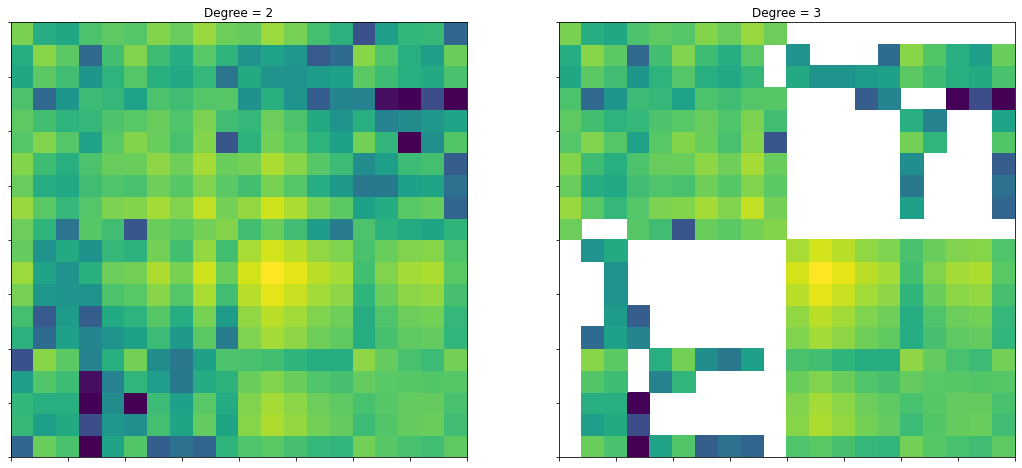

In [ ]:
_, axes = plt.subplots(1, 2, figsize=[18,8])

for n in range(2):
  d = n + 2
  G = poly_kernel(V, d)
  ax = axes[n]
  ax.pcolor(np.log(np.flipud(G)))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title('Degree = ' + str(d))
  # axes[n].colorbar()

plt.show()

グラム行列の成分間の値の差が大きいので、対数値を表示します。

- $d = 2$では、おぼろげではありますが、左上と右下の部分行列が区別できます。
- $d = 3$では、左上と右下の部分行列が明瞭に区別できていることが分かります。

従って、分類問題を解く場合には、
$d = 3$として多項式カーネルを利用した方が良い結果が得られる可能性が高いことが推察されます。

著者当てゲームのデータについてもグラムカーネルを計算してみましょう。

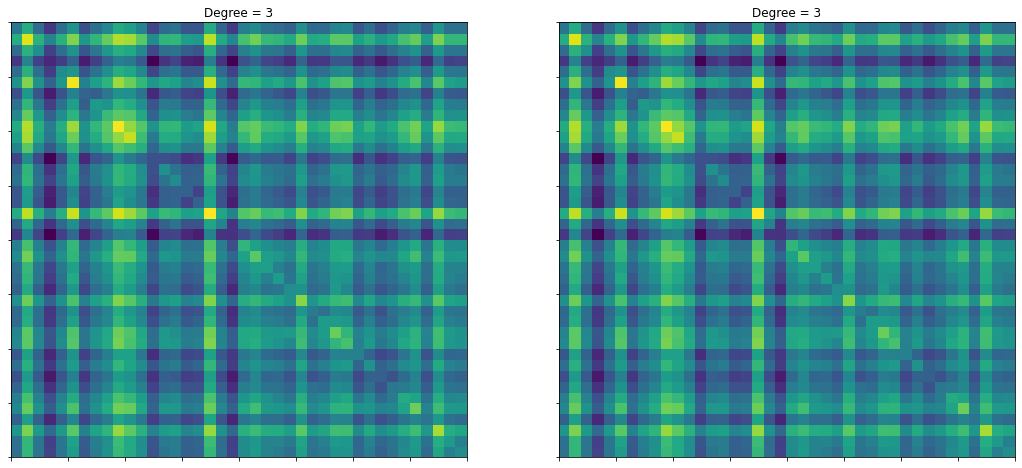

In [ ]:
poly_matrix = [poly_kernel(raw_vector, 2), poly_kernel(raw_vector, 3)]

_, axes = plt.subplots(1, 2, figsize=[18,8])

for n in range(2):
  ax = axes[n]
  ax.pcolor(np.log(np.flipud(poly_matrix[n])))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title('Degree = ' + str(d))
  # axes[n].colorbar()

plt.show()

$d = 2, 3$のいずれの場合においても、左上の部分行列と右下の部分行列をうまく区別できているようには見えません。
多項式カーネルを利用しても、うまく分類問題を解くことは難しいことが予感されます。


多項式カーネルをもちいることにより、線形分離不可能な分布を線形分離な分布に変換できる場合があることが知られています。。
以下では、よく知られた有名な例を見ていきます。

まず$-2 \le v_1 \le 2$、$-2 \le v_2 \le 2$の領域でランダムに点をプロットしたデータを作ります。分類するクラスは、$\sqrt{v_1^2 + v_2^2} \le 1$の範囲にある点を0、それ以外の点を1として、それぞれ500個にしました。

In [ ]:
pos_data_num = 500
neg_data_num = 500
total_num = pos_data_num + neg_data_num
v = np.zeros((total_num,2))
Y = np.zeros(total_num, dtype = int)
v[:pos_data_num,0] = 2 * np.random.rand(pos_data_num) - 1
v[pos_data_num:total_num,0] = 4 * np.random.rand(neg_data_num) - 2
for i in range(pos_data_num):
  v[i,1] = 2 * np.sqrt(1 - v[i,0] ** 2) * np.random.rand() - np.sqrt(1 - v[i,0] ** 2)
  Y[i] = 0
for i in range(neg_data_num):
  v[i+pos_data_num,1] = np.sign(np.random.rand() - 1/2) * ((2 - np.sqrt(max(1 - v[i+pos_data_num,0] ** 2, 0))) * np.random.rand() + np.sqrt(max(1 - v[i+pos_data_num,0] ** 2, 0)))
  Y[i+pos_data_num] = 1

実際にデータがどのような分布になっているのか可視化してみましょう。

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=v[:pos_data_num,0], y=v[:pos_data_num,1],
                    mode='markers',
                    name='positive',
                    # marker = dict(
                    #     color = Y[:pos_data_num])
                    ))
fig.add_trace(go.Scatter(x=v[neg_data_num:total_num,0], y=v[neg_data_num:total_num,1],
                    mode='markers',
                    name='negative',
                    # marker = dict(
                    #     color = Y[pos_data_num:total_num])
                    ))

fig.update_layout(title='Non linear data',
                  width = 800, height = 800,
                  xaxis=dict(title=r'$v_1$'),
                  yaxis=dict(title=r'$v_2$'))

fig.show()

このように原点を中心とした半径1の円の中に入っている点に関しては0を、入っていない点に関しては1というクラスを与えられていることがわかります。次にそれぞれの点の個数を見ていきます。

In [ ]:
count0 = len(Y[Y == 0])
count1 = len(Y[Y == 1])
print(f"クラス0の個数は{count0}個、クラス1の個数は{count1}個")

クラス0の個数は500個、クラス1の個数は500個


それぞれ500個ずつあることがわかりました。

このグラフを見ていただくとわかるように、明らかに直線でクラスを分類することができないデータになっています。

ここで2次の多項式カーネル

$$
L_{X^2} (x,y) = v_1(x)^2 \cdot v_1(y)^2 + (\sqrt{2} v_1(x)v_2(x)) \cdot (\sqrt{2} v_1(y)v_2(y)) + v_2(x)^2 \cdot v_2(y)^2
$$

について考えてみます。

このカーネル関数を、新しい特徴ベクトル

$$
\boldsymbol{w}(x) = (w_1(x),w_2(x),w_3(x))
$$

$$
w_1(x) = v_1(x)^2, \, w_2(x) = \sqrt{2} \cdot v_1(x)v_2(x), \, w_3(x) = v_2(x)^2
$$

を使って表現し直すと、

$$
L_{X^2} (x, y) = w_1(x)w_1(y) + w_2(x)w_2(y) + w_3(x)w_3(y)
$$

と、3次元の特徴ベクトル$(w_1, w_2, w_3)$の線形カーネルになることが分かるでしょう。

同じデータを、座標$(w_1, w_2, w_3)$に関して、3次元空間に表示してみましょう。


In [ ]:
w1 = v[:,0] ** 2
w2 = np.sqrt(2)*v[:,0]*v[:,1]
w3 = v[:,1] ** 2

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=w1, y=w3, z=w2,
                                   mode='markers',
                                   marker=dict(
                                   color=Y,
                                   size = 3          
    ))])

fig.update_layout(title='Non linear data',
                  width = 800, height = 800,
                  scene=dict(
                  xaxis=dict(title='w1'),
                  yaxis=dict(title='w3'),
                  zaxis=dict(title='w2')
    ))
fig.show()

グラフをクリックでホールドして、動かしてみて下さい。
正例と負例が平面を境界として分離されていることが分かる蓮です。

実は、

$$
v_1^2 + v_2^2 = w_1 + w_2
$$

なので、
$w_1$-$w_3$平面にデータを写像してみます。

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=w1, y=w3,
                    mode='markers',
                    marker = dict(
                        color = Y)
                    ))
fig.update_layout(title='Non linear data',
                  width = 800, height = 800)
fig.show()

確かに、$w_1 + w_3 = 1$の直線により、正例と負例が分離されていることが分かるでしょう。

分類アルゴリズムによっては、データが線形分離可能なように分布していなければ、
正しく分類問題を解くことができません。
そのような時に、多項式カーネルや、後述するガウスカーネルを利用することで、
分類問題を正しく解くことが可能となります。

### 4.1.4 ガウスカーネル(RBFカーネル)

最後にガウスカーネル(RBFカーネル)について考えましょう。ガウスカーネルは以下のように定義されます。

$$
G(x, y) = e^{-\gamma \| \vec v(x) - \vec v(y) \| ^2}
$$

ガウスカーネルは、
有限次元の特徴ベクトル$\vec v(x)$を、
無限次元の特徴ベクトルに写像し、
無限次元空間における特徴ベクトルの内積の値を計算します。
そのため、多項式カーネルと同様、線形非分離な分布を線形分離可能な分布に変換する効果を持ちます。

人工データセットに対して、ガウスカーネルのグラム行列を計算してみます。

In [ ]:
def gauss_kernel(V,gamma):
  G = np.zeros((V.shape[0], V.shape[0]))
  for i in range(V.shape[0]):
    for j in range(V.shape[0]):
      G[i,j] = np.exp(-gamma * (np.linalg.norm(V[i,:] - V[j,:], ord = 2) ** 2))
  return G

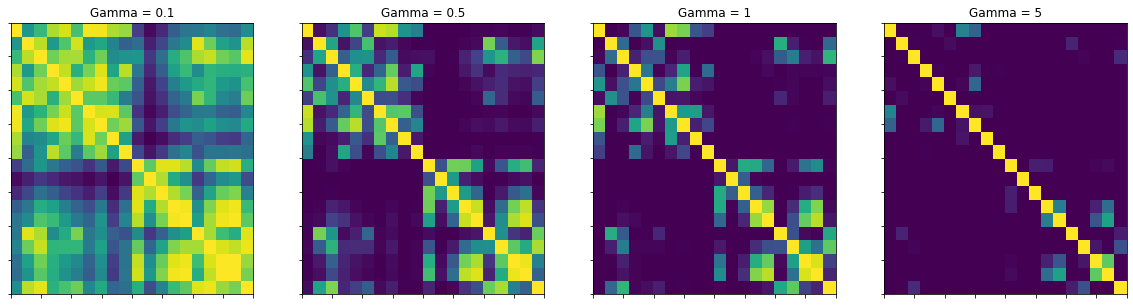

In [ ]:
_, axes = plt.subplots(1, 4, figsize=[20,5])

gammas = [0.1, 0.5, 1, 5]

for n in range(4):
  gamma = gammas[n]
  G = gauss_kernel(V, gamma)
  ax = axes[n]
  ax.pcolor(np.flipud(G))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title('Gamma = ' + str(gamma))
  # axes[n].colorbar()

plt.show()

ガウスカーネルのハイパーパラメータ$\gamma$の値が1以下である時、
左上の部分行列と右下の部分行列が色分けされていることが分かると思います。

部分行列が色分けされるということは、カーネルの値、つまり、類似度関数の評価によってデータが正しく区別されることを意味し、
分類問題がうまく解ける可能性を示唆しています。

一方、$\gamma = 5$では、カーネル値によるデータの区別は曖昧になり、
最適なハイパーパラメータの選択であるとはいえないことになります。なります。

著者当てゲームのデータに対して、同様にグラム行列を計算してみます。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in log



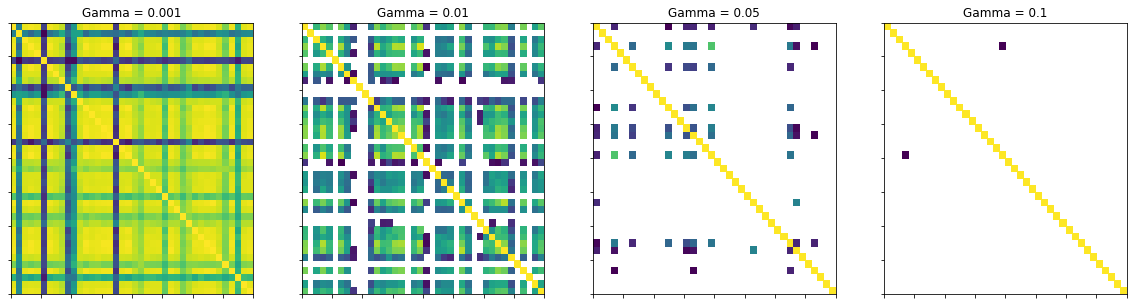

In [ ]:
_, axes = plt.subplots(1, 4, figsize=[20,5])

gammas = [0.001, 0.01, 0.05, 0.1]

for n in range(4):
  gamma = gammas[n]
  G = gauss_kernel(raw_vector, gamma)
  ax = axes[n]
  ax.pcolor(np.log(np.flipud(G)))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title('Gamma = ' + str(gamma))
  # axes[n].colorbar()

plt.show()

$\gamma = 0.05$の時に、比較的部分行列の色分けが明瞭であることが分かります。
従って、
著者当てゲームにおいては、
$\gamma = 0.05$がハイパーパラメータの選択としては適切であると考えて良さそうです。

## 4.2 カーネルマシン

カーネルマシンは以下のように特徴付けされます。

1.   カーネルマシンへの入力は、訓練データに関して、カーネル関数により計算される類似度行列と訓練データのラベルである。
2.   学習過程は各訓練データの特徴ベクトルへの操作として解釈することができる。

つまり、カーネルマシンは元のデータの特徴の次元より高次元の特徴ベクトルで表現されるデータの学習を、同じ計算量オーダーで処理することができるというメリットがあります。データを高次元の特徴ベクトルで表現することは、より複雑な出力が可能になるということであり、モデルの適用範囲を広げることができます。以降では実際に3つのカーネルマシンを用いて、カーネルの実用性を確認しましょう。



### 4.2.1 サポートベクターマシン

サポートベクターマシン(SVM)は「分離超平面と最も近い訓練データの特徴ベクトルとの距離(マージン)」を最大にするように学習する分類アルゴリズムです。SVMにはハードマージンSVM(超平面で分離できないデータには使えない)とソフトマージンSVM(学習においてペナルティを加えることによって、すべてのデータに使える)の2種類のアルゴリズムがありますが、今回は現在よく使われているソフトマージンSVMの最適化問題は

$
f(\alpha_1, \cdots, \alpha_{n^+}, \beta_1, \cdots, \beta_{n^-}, b) = \sum_i^{n^+}\sum_j^{n^+} \alpha_i \alpha_j k(x_i^+, x_j^+) + \sum_i^{n^-}\sum_j^{n^-} \beta_i \beta_j k(x_i^-, x_j^-) + 2\cdot\sum_i^{n^+}\sum_j^{n^-} \alpha_i \beta_j k(x_i^+, x_j^-) + C \left( \sum_i^{n^+} max \{ 0, 1 - \sum_j^{n^+} \alpha_j k(x_j^+, x_i^+) - \sum_j^{n^-} \beta_j k(x_j^-, x_i^+) - b \} + \sum_i^{n^-} max \{ 0, 1 + \sum_j^{n^+} \alpha_j k(x_j^+, x_i^-) + \sum_j^{n^-} \beta_j k(x_j^-, x_i^-) + b \} \right)
$

のようにカーネル関数のみで表すことができ、カーネル関数を計算(グラム行列を入力)して最適化することが可能です。まずは線形カーネルを用いてカーネルSVMの実装をしていきましょう。

データとして、1章で用いたワインのデータを用います。1章と同様にデータをダウンロードして整形しましょう。

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
ds = datasets.load_wine()
wine = pd.DataFrame(ds.data, columns = ds.feature_names)
wine['types'] = np.array(ds.target)
wine

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  types  
0                            3.92   1065.0      0  
1                            3.40   1050.0      0  
2                            3.17   1185.0      0  
3                            3.45   1480.0      0  
4                            2.93    735.0      0  
..                            ...      ...    ...  
173                          1.74    740.0      2  
174                          1.56    750.0      2  
175                          1.56    835.0      2  
176                          1.62    840.0      2  
177                          1.60    560.0      2  

[178 rows x 14 columns]

In [ ]:
import pandas as pd
import plotly.express as px

feature1 = "alcohol"
feature2 = "ash"

wine_clf = wine[[feature1,feature2,"types"]][wine.types != 2].copy()
wine_clf[[feature1,feature2]] -= wine_clf[[feature1,feature2]].mean(axis=0)
wine_clf[[feature1,feature2]] /= wine_clf[[feature1,feature2]].std(axis=0)
X = wine_clf[[feature1,feature2]].values
Y = wine_clf["types"].values
wine_clf["types"] = wine_clf["types"].apply(lambda x : str(x)).copy()
fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)
fig.show()

今回はscikit-learn(sklearn)を使ってSVMを実装していきましょう。
カーネルソフトマージンSVMにおいて決めるべき基本的なパラメータは、マージンとペナルティの間の学習における優先度を決める"C"と、使用するカーネルを決める"kernel"があり、それぞれの"kernel"によってカーネル関数を計算する際に必要なパラメータが存在します。

sklearnの"kernel"パラメータにはを"precomputed"というカテゴリがあり、通常のように行をデータ、列を特徴とする行列を入力する代わりに、グラム行列を入力することでSVMを学習することができます。

今回はこの"precomputed"を用いて、linear kernelを使って計算したグラム行列を入力してSVMを学習していきましょう。

In [ ]:
from sklearn import svm

G = linear_kernel(X)

model = svm.SVC(C = 1.0, kernel = "precomputed")
model.fit(G, Y)

SVC(kernel='precomputed')

次に実際にどのくらい分類できているか確かめてみましょう。まずは混同行列を見てみます。"precomputed"を選択している場合は、予測値が

$
\mathrm{sgn}(\sum_i^{n^+}\alpha _i k(x_i^+, x) + \sum_i^{n^-}\beta_i k(x_i^-, x) + b)
$

のようにグラム行列の値によって表されることから、予測する際に訓練データと予測するデータの間のグラム行列を入力します。今回は訓練データで予測を行っているので元と同じグラム行列を入力しましょう。

In [ ]:
from sklearn.metrics import confusion_matrix

pred = model.predict(G)
confusion_matrix(Y, pred)

array([[54,  5],
       [ 5, 66]])

データの中でどのような分類線が引かれているのか可視化してみます。

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
G_g = linear_kernel(np.r_[X, np.c_[x_g.ravel(), y_g.ravel()]])
z_g = model.predict(G_g[X.shape[0]:, :X.shape[0]])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

直観的に正しそうな領域に直線が引かれていることがわかりました。

sk-learnののsvmの実装は線形カーネルを内部で計算する機能を含んでいるため、
線形カーネルを自分で計算する必要はありません。ありません。
`kernel`という名前のパラメータに「線形」を意味する「「linear」を指定します。

In [ ]:
from sklearn import svm

model = svm.SVC(C = 1.0, kernel = "linear")
model.fit(X, Y)

SVC(kernel='linear')

In [ ]:
pred = model.predict(X)
confusion_matrix(Y, pred)

array([[54,  5],
       [ 5, 66]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
z_g = model.predict(np.c_[x_g.ravel(), y_g.ravel()])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

元の結果と同じ結果になりました。

クラスを分離する分離直線を引いてみましょう。

In [ ]:
w0 = model.intercept_
w1 = model.coef_[0,0]
w2 = model.coef_[0,1]

a = -w1/w2
b = -w0/w2

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(name='line of best fit', x=X[:,0], y=a*X[:,0] + b, mode='lines'))

fig.update_layout(yaxis_range=[np.amin(X[:,1]), np.amax(X[:,1])])


次にパラメータ"C"についてみていきましょう。

分離直線を境界に、右側がクラス0（青色のプロット）、
左側がクラス1（赤色のプロット）の領域になりますが、
例外（左の領域に存在する青いプロット・右の領域に存在する赤いプロット）が
存在することも分かります。

これらの例外をどれくらい許容するかで、分離直線の引き方が決定されます。決定されます。

ハイパーパラメータ$C$が例外に対するペナルティの重みを決定しますが、決定します。。
- $C$が小さければ、例外をより多く許容します。
- $C$が大きければ、例外をより多く排除します。

＄C$の値を変えると、分離直線がどのように変化するかを見てみます。

In [ ]:
C_list = np.array([3e-3, 5e-3, 1e-2, 1.0, 1e5])
l_param = np.zeros((C_list.shape[0],2))
c_matrix = np.zeros((C_list.shape[0],2,2))

for i in range(C_list.shape[0]):
  model = svm.SVC(C = C_list[i], kernel = "linear")
  model.fit(X, Y)
  pred = model.predict(X)
  c_matrix[i] = confusion_matrix(Y, pred)
  l_param[i,0] = - model.coef_[0,0] / model.coef_[0,1]
  l_param[i,1] = - model.intercept_ / model.coef_[0,1]
  print(f"confusinmatrix is {c_matrix[i]} at C = {C_list[i]}")


confusinmatrix is [[ 0. 59.]
 [ 0. 71.]] at C = 0.003
confusinmatrix is [[45. 14.]
 [ 1. 70.]] at C = 0.005
confusinmatrix is [[53.  6.]
 [ 5. 66.]] at C = 0.01
confusinmatrix is [[54.  5.]
 [ 5. 66.]] at C = 1.0
confusinmatrix is [[54.  5.]
 [ 5. 66.]] at C = 100000.0


In [ ]:
fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

for i in range(C_list.shape[0]):
  fig.add_trace(go.Scatter(name = f"C = {C_list[i]}", x=X[:,0], y=l_param[i,0]*X[:,0] + l_param[i,1], mode='lines'))

# fig.update_layout(yaxis_range=[np.amin(X[:,1]), np.amax(X[:,1])])

fig.show()

データには誤差が含まれていたり、また、「外れ値」と呼ばれる希にしか発生しない得意なデータが存在したりします。
従って、例外を度を過ぎて排除すると、正しい分離曲線を得ることができなくなってしまいます。
このような状態を、過適合（オーバーフィッティング）と呼びます。

- $C$の値をあまりに大きくとると、例外によるペナルティが大きくなって、
過適合の状態に陥りやすくなります。
- $C$の値が小さすぎると、例外が多くなりすぎ、適切な分類ができているとはいえなくなります。

2章で見たとおり、ハイパーパラメータの最適化によって、適切な$C$の値を探索しますが、
このとき、訓練データとテストデータを分ける交差検証法などの手法を利用することが重要です。


次に、線形カーネルに替えて、コサイン類似度を利用してみます。

sklearnのSVMの"kernel"パラメータにはコサイン類似度が存在しませんので、
"precomputed"でグラム行列を入力して計算していきましょう。

In [ ]:
from sklearn import svm

G = cos_kernel(X)

model = svm.SVC(C = 1.0, kernel = "precomputed")
model.fit(G, Y)

SVC(kernel='precomputed')

In [ ]:
from sklearn.metrics import confusion_matrix

pred = model.predict(G)
confusion_matrix(Y, pred)

array([[55,  4],
       [ 6, 65]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
G_g = cos_kernel(np.r_[X, np.c_[x_g.ravel(), y_g.ravel()]])
z_g = model.predict(G_g[X.shape[0]:, :X.shape[0]])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))


fig.show()

グラフを見てみると直線が原点で折れ曲がったような形をしています。
この理由は次のように説明することができます。

コサイン類似度は、$L^2$正規化を施した特徴ベクトルをlinear kernelで分類することと同義です。

訓練データを訓練データに$L^2$正規化を施すと、
原点を中心とし、半径が1の円周の上にデータが並びます。


In [ ]:
X_norm = 1 / np.linalg.norm(X, ord = 2, axis = 1)
X_l2 = np.dot(np.diag(X_norm), X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=X_l2[:,0], y=X_l2[:,1], mode='markers',
    marker=dict(color=Y)))
fig.update_layout(width=600, height=600)

fig.show()




正規化した訓練データに対して、線形カーネルを使ってSVMで分離直線を計算します。

In [ ]:
model = svm.SVC(C = 1.0, kernel = "linear")
model.fit(X_l2, Y)

SVC(kernel='linear')

In [ ]:
pred = model.predict(X_l2)
confusion_matrix(Y, pred)

array([[55,  4],
       [ 6, 65]])

In [ ]:
w0 = model.intercept_
w1 = model.coef_[0,0]
w2 = model.coef_[0,1]

a = -w1/w2
b = -w0/w2

fig = go.Figure()
fig.add_trace(go.Scatter(x=X_l2[:,0], y=X_l2[:,1], mode='markers',
    marker=dict(color=Y)))

fig.add_trace(go.Scatter(name='line of best fit', x=X_l2[:,0], y=a*X_l2[:,0] + b, mode='lines'))

fig.update_layout(width=600, height=600)

fig.update_layout(yaxis_range=[np.amin(X_l2[:,1]), np.amax(X_l2[:,1])])
fig.update_layout(xaxis_range=[np.amin(X_l2[:,0]), np.amax(X_l2[:,0])])

一方、予測を行うとき、原点を始点とする半直線上の任意の点と、訓練データのコサイン類似度は常に等しいことから、
半直線上の点に相当するデータに対する予測は常に等しくなります。

従って、分離直線と円周の2つの交点ををP, Qとするとき、するとき、
半直線OPととOQで挟まれた領域が同じクラスに予測される領域になります。

続いて、多項式カーネルについて考えていきましょう。

sklearnには"kernel"パラメータに"poly"を指定することで、
多項式カーネルを計算させることができますが、
まずは、"precomputed"を指定して
外でで計算したグラム行列を入力して学習してみましょう。

sklearnで指定できる多項式カーネルは

$$
k(x, y) = \left( \gamma L(x, y) + r\right)^d
$$

と定義され、
パラメータのデフォルト値は
$d = 3, r = 0, \gamma = $"scale"です。

$\gamma$の"scale"の指定は、

$$
\gamma = \frac 1{特徴数\times データの分散}
$$

を用いることを意味します。

今、データ$x, y$の特徴ベクトルを
$(v_1(x), \dots, v_n(x)), (v_1(y), \dots, v_n(y))$、
特徴値の分散を$\sigma^2$とするとき、

$$
\gamma L(x, y) = 
\frac 1{n \sigma^2}\sum_{i=1}^n v_i(x) v_i(y) = 
\frac 1n\sum_{i=1}^n \frac{v_i(x)}\sigma \frac{v_i(y)}\sigma
$$

が成り立つので、

これはデータの特徴数が増えるほど、またデータの分散が増えるほど内積(linear kernel)の値が増加していくため、スケーリングを行っているものです。

$\gamma$の値によってどのように分類が変化するかは後で見ていきましょう。

In [ ]:
from sklearn import svm

def poly_kernel(V, d, gamma, r):
  G = (gamma*np.dot(V, V.T) + r)**d
  return G

d = 3
gamma = 1 / (X.shape[1]*X.var())
r = 0
G = poly_kernel(X, d, gamma, r)

model = svm.SVC(C = 1.0, kernel = "precomputed")
model.fit(G, Y)

SVC(kernel='precomputed')

In [ ]:
from sklearn.metrics import confusion_matrix

pred = model.predict(G)
confusion_matrix(Y, pred)

array([[50,  9],
       [ 2, 69]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
G_g = poly_kernel(np.r_[X, np.c_[x_g.ravel(), y_g.ravel()]], d, gamma, r)
z_g = model.predict(G_g[X.shape[0]:, :X.shape[0]])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()


線形カーネル・コサイン類似度の場合と異なり、
クラスクラス0と1の境界が曲線になったことが分かると思います。。

同じ処理を"kernel"パラメータの値を"poly"にして行います。

In [ ]:
from sklearn import svm

d = 3
r = 0
model = svm.SVC(C = 1.0, kernel = "poly", degree = d, gamma = "scale", coef0 = r)
model.fit(X, Y)

SVC(coef0=0, kernel='poly')

In [ ]:
pred = model.predict(X)
confusion_matrix(Y, pred)

array([[50,  9],
       [ 2, 69]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
z_g = model.predict(np.c_[x_g.ravel(), y_g.ravel()])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

類似度行列としてグラム行列を入力した場合と同じ分類結果を得ています。

次に、次元を高くすると分類結果にどのような影響が出るのかについて、
$d = 6, 9$の場合に調べます。

$r = 1$に設定します。

In [ ]:
d = 9
r = 1
model = svm.SVC(C = 1.0, kernel = "poly", degree = d, gamma = "scale", coef0 = r)
model.fit(X, Y)

SVC(coef0=1, degree=9, kernel='poly')

In [ ]:
pred = model.predict(X)
confusion_matrix(Y, pred)

array([[58,  1],
       [ 5, 66]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
z_g = model.predict(np.c_[x_g.ravel(), y_g.ravel()])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

グラフのように多項式の次元を上げていくと分離超平面としてより複雑な関数を描くようになります。青い点を見ると正確に分類できているように思われるかもしれないですが、明らかに訓練データに過適合(over fitting)しています。次元は上げすぎないほうが汎化性能を保つためには十丁です。次に$\gamma$についてみていきましょう。$\gamma$は今$1 /$(特徴数*データの分散)という値になっていますが、もっと高い値にした場合はどうなるでしょうか。先ほどの$d = 9$に加えて実行してみます。

In [ ]:
d = 9
r = 1
model = svm.SVC(C = 1.0, kernel = "poly", degree = d, gamma = 1, coef0 = r)
model.fit(X, Y)

SVC(coef0=1, degree=9, gamma=1, kernel='poly')

In [ ]:
pred = model.predict(X)
confusion_matrix(Y, pred)

array([[58,  1],
       [ 2, 69]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
z_g = model.predict(np.c_[x_g.ravel(), y_g.ravel()])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

直観的にさっきの分類線よりも複雑で過適合したように思えます。$\gamma$を高くしていくとそれだけ高次元の係数が比較して高くなっていくのでより複雑な分類になりやすいと考えることができます。データに応じてこれらのパラメータを適切に調節することが肝要です。

最後にgauss kernelについて考えていきましょう。まずはこれまでと同様にグラム行列を入力して学習していきます。パラメータは$\gamma$のみでsklearnの初期値はpoly kernelと同様、"scale"です。

In [ ]:
gamma = 1 / (X.shape[1]*X.var())
G = gauss_kernel(X, gamma)

model = svm.SVC(C = 1.0, kernel = "precomputed")
model.fit(G, Y)

SVC(kernel='precomputed')

In [ ]:
pred = model.predict(G)
confusion_matrix(Y, pred)

array([[55,  4],
       [ 5, 66]])

※次のセルは実行にcolab環境で22分程度かかるので注意してください。

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
G_g =gauss_kernel(np.r_[X, np.c_[x_g.ravel(), y_g.ravel()]], gamma)
z_g = model.predict(G_g[X.shape[0]:, :X.shape[0]])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

非線形な分類ができました。次にsklearnでも実装してみましょう。

In [ ]:
model = svm.SVC(C = 1.0, kernel = "rbf", gamma = "scale")
model.fit(X, Y)

SVC()

In [ ]:
pred = model.predict(X)
confusion_matrix(Y, pred)

array([[55,  4],
       [ 5, 66]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
z_g = model.predict(np.c_[x_g.ravel(), y_g.ravel()])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

グラフを見ると同じ結果が出ていることがわかると思います。続いて$\gamma$について考えてみます。$\gamma$の値を増やしていくとどのような分類になるでしょうか。

In [ ]:
gamma = 2
model = svm.SVC(C = 1.0, kernel = "rbf", gamma = gamma)
model.fit(X, Y)

SVC(gamma=2)

In [ ]:
pred = model.predict(X)
confusion_matrix(Y, pred)

array([[59,  0],
       [ 5, 66]])

In [ ]:
x = np.linspace(np.amin(X[:,0]), np.amax(X[:,0]), 100)
y = np.linspace(np.amin(X[:,1]), np.amax(X[:,1]), 100)
x_g, y_g = np.meshgrid(x, y)
z_g = model.predict(np.c_[x_g.ravel(), y_g.ravel()])
z_g2 = z_g - 0.5

fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)

fig.add_trace(go.Scatter(x=x_g.ravel(), y=y_g.ravel(), mode='markers',
    marker=dict(color=z_g2, opacity = 0.2)))

fig.show()

グラフを見ると非常に複雑な関数になっており、過学習されていることがわかります。gauss kernelの式を見ていただくとわかる通り、$\gamma$の値はデータ間の影響がどれだけ遠くに伝わるかということを表しています。例えば$\gamma$が小さいと、データ間の影響はより遠くのデータまで作用しますので、遠くのデータからも大きく作用された分離超平面は単純で直線に近いものになります。逆に$\gamma$が大きいと、データは近い領域にしか影響を及ぼさないので、それだけ複雑で過学習された分離超平面は計算されます。poly kernelの時と同様にデータに応じて適切な$\gamma$を選択することが肝要です。

#### 課題 2.
シグモイド関数について、グラム行列を計算してからカーネルSVMを計算してみましょう。また自分でパラメーターを変更してどのような変化が現れるか確かめましょう。

### 4.2.2 カーネル線形回帰

続いてカーネルリッジ回帰について学んでいきましょう。カーネルリッジ回帰の最適化問題もSVMと同様に

$
R(\alpha_1, \cdots, \alpha_n, b) = \sum_i^n(y_i - \alpha_1 k(x_1, x_i) - \cdots - \alpha_n k(x_n, x_i) - b)^2 + \lambda \left( b^2 + \sum_i^n \sum_j^n \alpha_i \alpha_j \cdot k(x_i,x_j) \right)
$

を最小化する問題として、カーネル関数の値のみで表すことができます。SVMの時と同じようにkernelを変えながら回帰を行っていきましょう。

まずは回帰するデータを選択していきましょう。データは1章と同様にwineのデータを用います。回帰しているか見えやすいように相関係数の高いデータを用いましょう。

In [ ]:
wine

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  types  
0                            3.92   1065.0      0  
1                            3.40   1050.0      0  
2                            3.17   1185.0      0  
3                            3.45   1480.0      0  
4                            2.93    735.0      0  
..                            ...      ...    ...  
173                          1.74    740.0      2  
174                          1.56    750.0      2  
175                          1.56    835.0      2  
176                          1.62    840.0      2  
177                          1.60    560.0      2  

[178 rows x 14 columns]

In [ ]:
wine_corr = wine.corr()
print(wine_corr)

                               alcohol  malic_acid       ash  \
alcohol                       1.000000    0.094397  0.211545   
malic_acid                    0.094397    1.000000  0.164045   
ash                           0.211545    0.164045  1.000000   
alcalinity_of_ash            -0.310235    0.288500  0.443367   
magnesium                     0.270798   -0.054575  0.286587   
total_phenols                 0.289101   -0.335167  0.128980   
flavanoids                    0.236815   -0.411007  0.115077   
nonflavanoid_phenols         -0.155929    0.292977  0.186230   
proanthocyanins               0.136698   -0.220746  0.009652   
color_intensity               0.546364    0.248985  0.258887   
hue                          -0.071747   -0.561296 -0.074667   
od280/od315_of_diluted_wines  0.072343   -0.368710  0.003911   
proline                       0.643720   -0.192011  0.223626   
types                        -0.328222    0.437776 -0.049643   

                              alcalinit

"flavanoids"と"total_phenols"の間の相関が強そうです。グラフで確認してみましょう。

In [ ]:
feature1 = "flavanoids"
feature2 = "total_phenols"

wine_clf = wine[[feature1,feature2,"types"]][wine.types == 0].copy()
wine_clf[[feature1,feature2]] -= wine_clf[[feature1,feature2]].mean(axis=0)
wine_clf[[feature1,feature2]] /= wine_clf[[feature1,feature2]].std(axis=0)
X = wine_clf[[feature1,feature2]].values
Y = wine_clf["types"].values
wine_clf["types"] = wine_clf["types"].apply(lambda x : str(x)).copy()
fig = px.scatter(wine_clf, x = feature1, y = feature2, color = "types"
,width=600, height=600)
fig.show()

ちょうど良さそうなので、今回はこのデータを用いて回帰を行いましょう。

まずはlinear kernelを用いたカーネルリッジ回帰(ただのリッジ回帰)を行ってみましょう。SVM同様sklearnを用いますが、こちらの"kernel"パラメータにも"precomputed"が存在するのでこれを使ってグラム行列から学習をしていきます。カーネルリッジ回帰特有のパラメータとして上式における$\lambda$(正則化の強さを決めるパラメータ、sklearnでは"alpha")がありますが、初期値として$1.0$にしておきましょう。

In [ ]:
from sklearn.kernel_ridge import KernelRidge

G = linear_kernel(np.stack([X[:,0], np.zeros(X.shape[0])], 1))

model = KernelRidge(alpha=1.0, kernel='precomputed')
model.fit(G, X[:,1])

KernelRidge(alpha=1.0, kernel='precomputed')

In [ ]:
pred = model.predict(G)

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=X[:,0], y=pred, mode='lines'))

fig.update_layout(width=600, height=600)

グラフを見るときちんと直線を回帰できていることがわかります。続いて"linear"を用いて同じことを行っていきましょう、

In [ ]:
model = KernelRidge(alpha=1.0, kernel='linear')
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=1.0)

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=X[:,0], y=pred, mode='lines'))

fig.update_layout(width=600, height=600)

同じように回帰できました。ここでパラメータである$\lambda$を変えてみましょう。

In [ ]:
alpha_list = np.array([1e-3, 1.0, 10, 1e3, 1e5])
prediction = np.zeros((alpha_list.shape[0],X.shape[0]))

for i in range(alpha_list.shape[0]):
  model = KernelRidge(alpha=alpha_list[i], kernel='linear')
  model.fit(X[:,0].reshape(-1,1), X[:,1])
  prediction[i,:] = model.predict(X[:,0].reshape(-1,1))


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

for i in range(alpha_list.shape[0]):
  fig.add_trace(go.Scatter(name = f"lambda = {alpha_list[i]}", x=X[:,0], y=prediction[i,:], mode='lines'))

# fig.update_layout(yaxis_range=[np.amin(X[:,1]), np.amax(X[:,1])])
fig.update_layout(width=600, height=600)

fig.show()

$\lambda$が大きくなればなるほど直線の傾きが小さくなっていることがわかります。これは正則化項として、係数ベクトルの大きさ(傾き)が含まれているため、正則化が強くなればなるほど傾きは小さいほうが最適化関数を下げやすいからと考えられます。

次にcos kernelを用いて回帰を行ってみましょう。sklearnにはリッジ回帰にはcos kernelが存在しないため、グラム行列のみ実行してみましょう。

In [ ]:
G = cos_kernel(np.stack([X[:,0], np.zeros(X.shape[0])], 1))

model = KernelRidge(alpha=1.0, kernel='precomputed')
model.fit(G, X[:,1])

KernelRidge(alpha=1.0, kernel='precomputed')

In [ ]:
pred = model.predict(G)

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

全く回帰できていないことがわかると思います。そもそもcos kernelは大きさの情報を消して、角度で学習していくため回帰にはあまり向いていないと考えられます。

次に多項式カーネルについて考えていきましょう。パラメーターはSVMの時の初期値と同様です。まずはグラム行列を入力しましょう。

In [ ]:
d = 3
gamma = 1 / X[:,0].var()
r = 0
G = poly_kernel(np.stack([X[:,0], np.zeros(X.shape[0])], 1), d, gamma, r)

model = KernelRidge(alpha=1.0, kernel='precomputed')
model.fit(G, X[:,1])

KernelRidge(alpha=1.0, kernel='precomputed')

In [ ]:
pred = model.predict(G)

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

非線形な回帰ができていることがわかります。sklearnのリッジ回帰にはpoly kernelが存在するのでそちらの方でも同じ結果が出ることを確認します。

In [ ]:
gamma = 1 / X[:,0].var()
model = KernelRidge(alpha=1.0, kernel='poly', degree = 3, gamma = gamma, coef0 = 0)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=1.0, coef0=0, gamma=1.0172413793103448, kernel='poly')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

同じ結果が得られました。続いて回帰で$d$や$\gamma$パラメータを変化させた場合どうなるか見てみましょう。まずは$d = 9$,$r = 1$で実行します。

In [ ]:
gamma = 1 / X[:,0].var()
d = 9
model = KernelRidge(alpha=1.0, kernel='poly', degree = d, gamma = gamma, coef0 = 1)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=1.0, degree=9, gamma=1.0172413793103448, kernel='poly')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

続いて、$\gamma = 100$にしてみましょう。

In [ ]:
gamma = 100
d = 9
model = KernelRidge(alpha=1.0, kernel='poly', degree = d, gamma = gamma, coef0 = 1)
model.fit(X[:,0].reshape(-1,1), X[:,1])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:197: UserWarning:

Singular matrix in solving dual problem. Using least-squares solution instead.



KernelRidge(alpha=1.0, degree=9, gamma=100, kernel='poly')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

どちらの場合も元の回帰関数に比べて複雑になっていることがわかると思います。これまでと同様に訓練データに対して適合しすぎるケースがあるので注意が必要です。

最後にgauss kernelについて考えていきます。同様に最初にグラム行列から計算、次にライブラリを用いた計算を行います。

In [ ]:
gamma = 1 / X[:,0].var()
G = gauss_kernel(np.stack([X[:,0], np.zeros(X.shape[0])], 1), gamma)

model = KernelRidge(alpha=1.0, kernel='precomputed')
model.fit(G, X[:,1])

KernelRidge(alpha=1.0, kernel='precomputed')

In [ ]:
pred = model.predict(G)

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

In [ ]:
gamma = 1 / X[:,0].var()
model = KernelRidge(alpha=1.0, kernel='rbf', gamma = gamma)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=1.0, gamma=1.0172413793103448, kernel='rbf')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

ガウスカーネルでも同様に非線形な回帰が実行できました。

続いて、非線形な回帰がうまく作用するようなデータを試してみましょう。以下では$[-5,5]$の範囲で等間隔に並んでいるような$30$個の$x$に対して、$\sin(\frac{\pi}{2}x)+\epsilon$を計算したデータです。ここで$\epsilon$は$[-0.1,0.1]$の範囲で一様ランダムにサンプリングしたノイズになります。

In [ ]:
num_data = 30
X = np.array([np.linspace(-5,5,num_data), np.sin(np.pi/2*np.linspace(-5,5,num_data)) + 0.2 * np.random.rand(num_data) - 0.1]).T

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1],
                    mode='markers',
                    name='sin func',
                    # marker = dict(
                    #     color = Y[:pos_data_num])
                    ))
fig.update_layout(title='sin data',
                  width = 600, height = 600,
                  xaxis=dict(title=r'$x$'),
                  yaxis=dict(title=r'$f(x)$'))

fig.show()

まずは多項式カーネルから計算してみましょう。$d = 9$で試してみます。

In [ ]:
d = 9
gamma = 1 / X[:,0].var()
r = 1
model = KernelRidge(alpha=1.0, kernel='poly', degree = d, gamma = gamma, coef0 = r)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=1.0, degree=9, gamma=0.11225806451612905, kernel='poly')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

かなり傾向が似ている回帰の結果が得られました。もっと近づけるために$\lambda$を小さくしてみましょう。

In [ ]:
d = 9
gamma = 1 / X[:,0].var()
r = 1
model = KernelRidge(alpha=1e-3, kernel='poly', degree = d, gamma = gamma, coef0 = r)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=0.001, degree=9, gamma=0.11225806451612905, kernel='poly')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

先ほどよりも$\sin$関数の形に近づいたと思います。次にガウスカーネルについても見ていきましょう。

In [ ]:
gamma = 1 / X[:,0].var()
model = KernelRidge(alpha=1, kernel='rbf', gamma = gamma)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(gamma=0.11225806451612905, kernel='rbf')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

何となくそれっぽい感じの関数になりましたがまだあまりあっていません。こちらも同様に$\lambda$を下げてみましょう。

In [ ]:
gamma = 1 / X[:,0].var()
model = KernelRidge(alpha=1e-3, kernel='rbf', gamma = gamma)
model.fit(X[:,0].reshape(-1,1), X[:,1])

KernelRidge(alpha=0.001, gamma=0.11225806451612905, kernel='rbf')

In [ ]:
pred = model.predict(X[:,0].reshape(-1,1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=X[:,0], y=X[:,1], mode='markers'))

fig.add_trace(go.Scatter(name='line of best fit', x=np.sort(X[:,0]), y=pred[np.argsort(X[:,0])], mode='lines'))

fig.update_layout(width=600, height=600)

かなり近づきました。このように線形回帰ではどうやっても回帰できないような関数に対しても多項式カーネルやガウスカーネルを用いれば、回帰が可能になる場合があります。その一方で過学習を引き起こしやすくなるので、場面を見て使い分けるように注意しましょう。

#### 課題 2.
シグモイド関数について、グラム行列を計算してからカーネルリッジ回帰を計算してみましょう。また自分でパラメーターを変更してどのような変化が現れるか確かめましょう。

### 4.2.3 カーネル$k$平均法

最後のモデルとしてカーネル k-meansを考えていきます。k-meansはクラスタの中心とそのクラスタに属するデータとの距離を最小にするようなk個のクラスタを作るアルゴリズムです。カーネルk-meansの最適化問題は

$
R(\alpha_{11}, \cdots, \alpha_{1n}, \cdots, \alpha_{k1}, \cdots, \alpha_{kn}) = \sum_i^n min_j \left[ k(x_i, x_i) - \sum_l^n 2\alpha_{jl} k(x_i, x_l) + \sum_a^n \sum_b^n \alpha_{ja}\alpha_{jb} k(x_a, x_b) \right]
$

を最小にするパラメーターを探索するというもので、この最適化問題もカーネル関数の値を入力することで計算できます。

まずはクラスタリングしやすいデータを作っていきましょう。次のデータはxとyの期待値がそれぞれ$[[0.5, 0.5],[1.5, 0.5],[1, 1.5]]$で共分散行列が
$
\begin{pmatrix}
0.05 & 0 \\
0 & 0.05 \\
\end{pmatrix}
$
で与えられるような正規分布からそれぞれ1000点ずつサンプリングしたものになります。

In [ ]:
import scipy as sp
from scipy import stats as st

In [ ]:
k = 3
n = [300, 300, 300]
N = np.sum(n)
m_true = np.array([[0.5, 0.5],[1.5, 0.5],[1, 1.5]])

D = m_true.shape[1]

sigma_true = np.array([[[0.05, 0],[0, 0.05]],[[0.05, 0],[0, 0.05]],[[0.05, 0],[0, 0.05]]])

c = ['red', 'green', 'blue', "yellow"]
X = np.zeros((N,2))
Y = np.zeros(N)
count = 0
for i in range(k):
  X[count:count+n[i],:] = st.multivariate_normal.rvs(mean=m_true[i], cov=sigma_true[i], size=n[i])
  Y[count:count+n[i]] = np.ones(n[i]) * i
  count += n[i]
        

fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X[Y == i][:,0], y=X[Y == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

data1 = X[:,0:2].copy()

このデータをカーネルkmeansでクラスタリングしていきます。
カーネルk-meansはsklearnにはないので、今回は自分で実装していきます。余裕のある方はcodeを参考にしてください。

In [ ]:
class kernel_kmeans():
    def __init__(self, k, kernel="linear", param = None, stop_iter = 100):
      self.k = k
      self.kernel = kernel
      self.param = param
      self.stop_iter = stop_iter

    def gram_matrix(self):
      if self.kernel == "linear":
        self.G = self.linear_kernel(self.V)
      elif self.kernel == "cos":
        self.G = self.cos_kernel(self.V)
      elif self.kernel == "poly":
        self.G = self.poly_kernel(self.V, self.param["d"], self.param["gamma"], self.param["r"])
      elif self.kernel == "gauss":
        self.G = self.gauss_kernel(self.V, self.param["gamma"])
      elif self.kernel == "precomputed":
        self.G = self.V

    def distance_cluster(self):
      self.distance = np.zeros((self.num_data, self.k))
      for i in range(self.num_data):
        for j in range(self.k):
          self.distance[i,j] = self.G[i,i] - 2*np.dot(self.alpha[j,:], self.G[i,:]) + np.dot(self.alpha[j,:], np.dot(self.G, self.alpha[j,:]))

    def labeling(self):
      self.label[self.iter,:] = np.argmin(self.distance, axis = 1)
      self.size_cluster[self.iter,:] = np.bincount(self.label[self.iter,:])
      self.alpha = np.zeros((self.k, self.num_data))
      for i in range(self.num_data):
        self.alpha[self.label[self.iter,i],i] = 1 / self.size_cluster[self.iter, self.label[self.iter,i]]

    def fit(self, V):
      self.V = V
      self.num_data = V.shape[0]
      self.gram_matrix()
      self.label = np.zeros((self.stop_iter, self.num_data), dtype = int)
      self.size_cluster = np.zeros((self.stop_iter, self.k))
      self.label[0,:] = np.random.choice(range(self.k), self.num_data)
      self.size_cluster[0,:] = np.bincount(self.label[0,:])
      self.alpha = np.zeros((self.k, self.num_data))
      self.iter = 0
      for i in range(self.num_data):
        self.alpha[self.label[0,i],i] = 1 / self.size_cluster[0, self.label[0,i]]
      for i in range(self.stop_iter):
        self.iter += 1
        self.distance_cluster()
        self.labeling()
        if np.allclose(self.label[self.iter,:],self.label[self.iter-1,:]) == True:
          self.label = np.delete(self.label, np.s_[self.iter:self.stop_iter], axis = 0)
          break


    @staticmethod
    def linear_kernel(V):
      G = np.dot(V, V.T)
      return G

    @staticmethod
    def cos_kernel(V):
      V_nor = np.diag(1 / np.linalg.norm(V, ord = 2, axis = 1))
      V_new = np.dot(V_nor, V)
      G = np.dot(V_new, V_new.T)
      return G
    
    @staticmethod
    def poly_kernel(V, d, gamma, r):
      G = (gamma * np.dot(V, V.T) + r) ** d
      return G

    @staticmethod
    def gauss_kernel(V,gamma):
      G = np.zeros((V.shape[0], V.shape[0]))
      for i in range(V.shape[0]):
        for j in range(V.shape[0]):
          G[i,j] = np.exp(-gamma * (np.linalg.norm(V[i,:] - V[j,:], ord = 2) ** 2))
      return G

使い方はsklearnと同じような感じです。まずはlinear kernelから試していきましょう。"precomputed"は実装しておきましたが、今回は自分でグラム行列を計算しているようなものなので、いきなり"kernel"パラメータを指定していきます。

In [ ]:
model = kernel_kmeans(k = 3, kernel = "linear")
model.fit(X)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X[label[-1,:] == i][:,0], y=X[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

グラフのようにクラスタリングできました。元のデータと比較してみると重なっている部分以外はおおむね正確にクラスタリングできています。今回は自分で実装したので、クラスタリングの経過を観察できます。どのようにクラスタリングされているのか確かめてみましょう。より直観的に観察できるようにplotlyを用いて動的なグラフを作ります。

In [ ]:
def plot_figure(X,label):
  color_dict = {0: 'red', 1: 'green', 2: 'blue', 3:'yellow'}
  c = ['red', 'green', 'blue', 'yellow']

  fig_dict = {
      "data": [],
      "layout": {},
      "frames": []
  }


  fig_dict["layout"]["hovermode"] = "closest"
  fig_dict["layout"]["updatemenus"] = [
      {
          "buttons": [
              {
                  "args": [None, {"frame": {"duration": 500, "redraw": False},
                                  "fromcurrent": True, "transition": {"duration": 300,
                                                                      "easing": "quadratic-in-out"}}],
                  "label": "Play",
                  "method": "animate"
              },
              {
                  "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                  "label": "Pause",
                  "method": "animate"
              }
          ],
          "direction": "left",
          "pad": {"r": 10, "t": 87},
          "showactive": False,
          "type": "buttons",
          "x": 0.1,
          "xanchor": "right",
          "y": 0,
          "yanchor": "top"
      }
  ]

  sliders_dict = {
      "active": 0,
      "yanchor": "top",
      "xanchor": "left",
      "currentvalue": {
          "font": {"size": 20},
          "prefix": "Iteration:",
          "visible": True,
          "xanchor": "right"
      },
      "transition": {"duration": 300, "easing": "cubic-in-out"},
      "pad": {"b": 10, "t": 50},
      "len": 0.9,
      "x": 0.1,
      "y": 0,
      "steps": []
  }



  data_dict = {
              "x": X[:,0],
              "y": X[:,1],
              "mode": "markers",
              "marker": {
                  "color" : "gray",
              }
          }
  fig_dict["data"].append(data_dict)

  for _iter in range(label.shape[0]):
      color_point = np.empty(label.shape[1],dtype=object)
      for j in range(label.shape[1]):
        color_point[j] = color_dict[label[_iter,j]]


      frame = {"data": [], "name": str(_iter)}
      data_dict = {
              "x": X[:,0],
              "y": X[:,1],
              "mode": "markers",
              "marker": {
                  "color" : color_point,
              }
          }
      frame["data"].append(data_dict)

      fig_dict["frames"].append(frame)
      slider_step = {"args": [
          [_iter],
          {"frame": {"duration": 300, "redraw": False},
          "mode": "immediate",
          "transition": {"duration": 300}}
      ],
          "label": _iter,
          "method": "animate"}
      sliders_dict["steps"].append(slider_step)

  fig_dict["layout"]["sliders"] = [sliders_dict]

  fig = go.Figure(fig_dict)
  fig.update_layout(title='dynamics of k-means',
                  width = 600, height = 600)

  fig.show()

In [ ]:
plot_figure(X, label)

グラフのように最初はランダムなラベルからだんだんクラスタに分けられていく様子がわかると思います。

次にcos kernelを試していきましょう。

In [ ]:
model = kernel_kmeans(k = 3, kernel = "cos")
model.fit(X)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X[label[-1,:] == i][:,0], y=X[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(X, label)

グラフを見ればわかるようにうまくクラスタリングできていません。これはSVMの時に説明したように角度の情報でクラスタを分けているからだと考えられます。cos kernelでうまく分類ができるようにデータの中心を原点に移動してみましょう。

In [ ]:
X_c = X - np.ones(X.shape)

fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X_c[Y == i][:,0], y=X_c[Y == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

data1 = X[:,0:2].copy()

原点中心のデータになりました。このデータに対してcos kernelを用いていきましょう。

In [ ]:
model = kernel_kmeans(k = 3, kernel = "cos")
model.fit(X_c)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X_c[label[-1,:] == i][:,0], y=X_c[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(X_c, label)

うまくクラスタリングされました。cos kernelについてはデータと原点の位置が重要になってくるので注意が必要です。

次に多項式カーネルを用いてクラスタリングしてみましょう。

In [ ]:
d = 3
gamma = 1 / (X.shape[1] * X.var())
r = 1
param = {"d" : d, "gamma" : gamma, "r" : r}
model = kernel_kmeans(k = 3, kernel = "poly", param = param)
model.fit(X)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X[label[-1,:] == i][:,0], y=X[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(X, label)

linearに対して若干のずれはあるものの大まかにはクラスタリングできているように感じます。多項式カーネルが有効なデータについては後で考えてみましょう。

次にガウスカーネルについてみていきます。

In [ ]:
gamma = 1 / (X.shape[1] * X.var())
param = {"gamma" : gamma}
model = kernel_kmeans(k = 3, kernel = "gauss", param = param)
model.fit(X)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=X[label[-1,:] == i][:,0], y=X[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(X, label)

線形カーネルと同様にかなりうまくクラスタリングできていると感じます。

続いて多項式カーネルやガウスカーネルなどの非線形な結果を返すカーネル関数はどのようなデータに対して有効か考えてみましょう。まず4.1.3で紹介したようなデータに対してクラスタリングを実行してみましょう。今回は中心のデータと外側のデータを少し離します。

In [ ]:
pos_data_num = 200
neg_data_num = 200
total_num = pos_data_num + neg_data_num
v = np.zeros((total_num,2))
Y = np.zeros(total_num, dtype = int)
v[:pos_data_num,0] = 1 * np.random.rand(pos_data_num) - 0.5
rd_val = np.random.rand(neg_data_num)
v[pos_data_num:total_num,0] = 2 * np.cos(2 * np.pi * rd_val)
for i in range(pos_data_num):
  v[i,1] = 2 * np.sqrt(0.25 - (v[i,0] ** 2)) * np.random.rand() - np.sqrt(0.25 - (v[i,0] ** 2))
  Y[i] = 0
v[pos_data_num:,1] = 2 * np.sin(2 * np.pi * rd_val)
Y[pos_data_num:] = np.ones(neg_data_num)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=v[:pos_data_num,0], y=v[:pos_data_num,1],
                    mode='markers',
                    name='positive',
                    # marker = dict(
                    #     color = Y[:pos_data_num])
                    ))
fig.add_trace(go.Scatter(x=v[neg_data_num:total_num,0], y=v[neg_data_num:total_num,1],
                    mode='markers',
                    name='negative',
                    # marker = dict(
                    #     color = Y[pos_data_num:total_num])
                    ))

fig.update_layout(title='Non linear data',
                  width =600, height = 600,
                  xaxis=dict(title=r'$v_1$'),
                  yaxis=dict(title=r'$v_2$'))

fig.show()

グラフのようなデータに対して、まずは線形カーネルを用いてクラスタリングをしてみましょう。

In [ ]:
model = kernel_kmeans(k = 2, kernel = "linear")
model.fit(v)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=v[label[-1,:] == i][:,0], y=v[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(v, label)

線形カーネルだとグラフのように思ったようなクラスタリングはできません。続いて多項式カーネルを試してみましょう。4.1.3で考えたように$X^2$の形のカーネルを考えましょう。

In [ ]:
d = 2
gamma = 1 / (v.shape[1] * v.var())
r = 0
param = {"d" : d, "gamma" : gamma, "r" : r}
model = kernel_kmeans(k = 2, kernel = "poly", param = param)
model.fit(v)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=v[label[-1,:] == i][:,0], y=v[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(v, label)

想定したようなクラスタリングができませんでした。原因を考えるために特徴空間に写像して4.1.3のようなグラフを描いてみましょう。

In [ ]:
w1 = v[:,0] ** 2
w2 = np.sqrt(2)*v[:,0]*v[:,1]
w3 = v[:,1] ** 2

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=w1, y=w3,
                    mode='markers',
                    marker = dict(
                        color = Y)
                    ))
fig.update_layout(title='Non linear data',
                  width = 600, height = 600)
fig.show()

このグラフを見てもらうとわかるように、黄色のクラスター中心と黄色の端の点との間の距離は、黄色のクラスター中心と青の点との間の距離よりも若干長くなっていることがわかると思います。kmeansではクラスター中心からの距離を最小化するように最適化を行うので、うまくクラスタリングされなかったと考えられます。

ではどのようなクラスタリングならうまくいくでしょうか。次のようなデータを作ります。

In [ ]:
pos_data_num = 200
neg_data_num = 200
total_num = pos_data_num + neg_data_num
v_2 = np.zeros((total_num,2))
Y = np.zeros(total_num, dtype = int)
v_2[:pos_data_num,0] = 1 * np.random.rand(pos_data_num) - 0.5
rd_val = np.random.rand(neg_data_num)
v_2[pos_data_num:total_num,0] = 2 * np.cos(np.pi * rd_val / 2 - np.pi / 4 + np.random.randint(0,2,neg_data_num) * np.pi)
for i in range(pos_data_num):
  v_2[i,1] = 2 * np.sqrt(0.25 - (v_2[i,0] ** 2)) * np.random.rand() - np.sqrt(0.25 - (v_2[i,0] ** 2))
  Y[i] = 0
v_2[pos_data_num:,1] = 2 * np.sin(np.pi * rd_val / 2 - np.pi / 4)
Y[pos_data_num:] = np.ones(neg_data_num)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=v_2[:pos_data_num,0], y=v_2[:pos_data_num,1],
                    mode='markers',
                    name='positive',
                    # marker = dict(
                    #     color = Y[:pos_data_num])
                    ))
fig.add_trace(go.Scatter(x=v_2[neg_data_num:total_num,0], y=v_2[neg_data_num:total_num,1],
                    mode='markers',
                    name='negative',
                    # marker = dict(
                    #     color = Y[pos_data_num:total_num])
                    ))

fig.update_layout(title='Non linear data',
                  width = 800, height = 800,
                  xaxis=dict(title=r'$v_1$'),
                  yaxis=dict(title=r'$v_2$'))

fig.update_layout(yaxis_range=[-2, 2],
                  xaxis_range=[-2, 2])


fig.show()

グラフのようなデータに対して中心と外側でクラスタリングしていきましょう。線形カーネルで計算すると以下のようになります。

In [ ]:
model = kernel_kmeans(k = 2, kernel = "linear")
model.fit(v_2)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=v_2[label[-1,:] == i][:,0], y=v_2[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
  
fig.update_layout(yaxis_range=[-2.1, 2.1],
                  xaxis_range=[-2.1, 2.1])

fig.show()

In [ ]:
plot_figure(v_2, label)

グラフのように外側と内側を分けることはできません。多項式カーネルはどうでしょうか。

In [ ]:
d = 2
gamma = 1 / (v.shape[1] * v.var())
r = 0
param = {"d" : d, "gamma" : gamma, "r" : r}
model = kernel_kmeans(k = 2, kernel = "poly", param = param)
model.fit(v_2)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=v_2[label[-1,:] == i][:,0], y=v_2[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
  
fig.update_layout(yaxis_range=[-2.1, 2.1],
                  xaxis_range=[-2.1, 2.1])

fig.show()

In [ ]:
plot_figure(v_2, label)

今回は想定通りのクラスタリングができました。特徴空間の方も確認してみましょう。

In [ ]:
w1 = v_2[:,0] ** 2
w2 = np.sqrt(2)*v_2[:,0]*v_2[:,1]
w3 = v_2[:,1] ** 2

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=w1, y=w3,
                    mode='markers',
                    marker = dict(
                        color = Y)
                    ))
fig.update_layout(title='Non linear data',
                  width = 600, height = 600)
fig.show()

見ていただくとわかるように黄色のクラスター中心から黄色の端の点までの距離が短くなっていることが見て取れます。このように線形カーネルでクラスタリングできなくても多項式カーネルではクラスタリングできるケースが存在します。

次にガウスカーネルで元のデータに対してクラスタリングを実行してみましょう。

In [ ]:
gamma = 1 / (v.shape[1] * v.var())
param = {"gamma" : gamma}
model = kernel_kmeans(k = 2, kernel = "gauss", param = param)
model.fit(v)
label = model.label

In [ ]:
fig = go.Figure()
fig.update_layout(width=600, height=600)        
for i in range(k):
  fig.add_trace(go.Scatter(x=v[label[-1,:] == i][:,0], y=v[label[-1,:] == i][:,1],
                    mode='markers',
                    marker = dict(color = c[i]),
                    name=f'{i}'
                    ))
fig.show()

In [ ]:
plot_figure(v, label)

ガウスカーネルでは想定通りのクラスタリングができました。ガウスカーネルは複雑なデータに対しても高い適合度を持っていることがわかります。

これまでの流れでは最初にクラスタのラベルを想定して学習をしてきましたが、実際に使う際にはラベルはなくどのクラスタが正解というものはありません。どのようなデータに対して、どのようなクラスタ分けを行いたいかによってkernelやパラメータを使い分けていくことが重要です。

#### 課題 4.1.
シグモイド関数について、グラム行列を計算してからカーネルk-meansを計算してみましょう。また自分でパラメーターを変更してどのような変化が現れるか確かめましょう。

#### 課題 4.2.
3つのアルゴリズムのうち一つ選んで、自分の好きなデータ(作っても探してきてもよいです)を、シグモイド関数で計算してみましょう。

## 4.3 サポートベクターマシンによる著者当てゲーム
ここでは、2章で取り上げた著者当てゲームにおいて、「線形カーネル」「ガウスカーネル」「コサイン類似度」「ジャガール指数」によって類似度を評価し、カーネルソフトマージンSVMへの入力とします。それぞれで5分割交差検証を行い、正答率を算出します。

4章で取り挙げてきた学習アルゴリズム:SVMも「機械学習のフレームワーク」の中で使用されます。(以下「機械学習のフレームワーク」について教科書から引用)
>
>[機械学習のフレームワーク]
>
>1. 類似度関数は二つのデータを引数にとる「二変数関数」であり、データ間の類似度を定量化します。今回の場合、類似度関数としてカーネル関数を使用します。
1. $n$個のテキストデータ$x_1,…, x_n$から重複を許して2個のデータ$x_i, x_j$を取り、カーネル関数によって類似度$k(x_i, x_j)$を計算して、$n\times n$の類似度行列$\Sigma$を生成します。
$$\Sigma = 
\begin{pmatrix}
k(x_1, x_1) & \cdots  & k(x_1,x_n)\\
\vdots & \ddots & \vdots \\
k(x_n, x_1) &  \cdots & k(x_n, x_n)
\end{pmatrix} $$
1. 類似度行列とラベルを学習アルゴリズム(SVM)への入力とし、分離超平面を定めます。(モデルの取得)
1. テストデータ$z$から$\bigl(k(z, x_1), k(z, x_2), ..., k(z, x_m)\bigl)$を計算し、モデルに入力することで、出力としてテキストデータ$z$の著者についての予測結果を得ます。
>
では、2章の著者当てゲームと異なる「類似度関数」と「学習アルゴリズム」の部分に注意して、上のステップに従い著者当てゲームに再挑戦しましょう。


## 4.3.1 線形カーネル(著者当てゲーム)
始めに、最も簡単な線形カーネルに基づいて、著者当てゲームに取り組みます。

線形カーネルは$x,y$は作品の生テキスト、$\boldsymbol{v}(x),\boldsymbol{v}(y)$を特徴ベクトルとすると以下のように書けました。\
($N$は全作品に含まれる単語の種類の総数)
$$ L(x_i, x_j) = \boldsymbol{v}(x_i)  \cdot \boldsymbol{v}(x_j) = v_1(x_i)v_1(x_j) + v_2(x_i)v_2(x_j) + ... + v_N(x_i)v_N(x_j)$$

したがって、類似度行列を作成するためにテキストデータ$x_1, ..., x_{40}$から特徴ベクトル$\boldsymbol{v}(x_1), ..., \boldsymbol{v}(x_{40})$を生成する必要があります。\
2章の2.4節ではデータの加工を行い、文字の羅列だった生データから名詞・形容詞・動詞・副詞を抽出し、出現回数をまとめました。今回は2章で得た特徴抽出の結果をベクトル化して特徴ベクトルを生成しましょう。

2章で得た特徴抽出の結果は```hgram```にまとめられており、ここでは```hgram```を```raw_vector```というベクトルに変換します。




### hgramの準備
<font color= "red">**2章で行った内容と全く同じ内容を行います。実行ボタンのみ押せばhgramが作成できますのでそのようにしてください**</font>
もしセルを開いてしまい、閉じたいときは「hgramの準備」の左にある三角を押すとセルを閉じることができます。

In [ ]:
mkdir data

In [ ]:
cd data

In [ ]:
def proce(name, start, end):
  f = open(name, "r", encoding = "shift-jis").read()
  need_text = f[start:end]
  f = open(name, "w", encoding = "shift-jis")
  f.write(need_text)
  f.close()

In [ ]:
 #「羅生門」のテキストファイルを取り込んで解凍
name = "rashomon.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/127_ruby_150.zip
! unzip 127_ruby_150.zip
start = 298
end = -307
proce(name, start, end)

 # その他のテキストファイルもダウンロード

 # 芥川
name = "yoba.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/184_ruby_897.zip
! unzip 184_ruby_897.zip
start = 297
end = -355
proce(name, start, end)

name = "yabuno_naka.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/179_ruby_168.zip
! unzip 179_ruby_168.zip
start = 318
end = -332
proce(name, start, end)

name = "mujina.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/102_ruby_724.zip
! unzip 102_ruby_724.zip
start = 258
end = -292
proce(name, start, end)

name = "hana.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/42_ruby_154.zip
! unzip 42_ruby_154.zip
start = 262
end = -331
proce(name, start, end)

name = "haguruma.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/40_ruby_310.zip
! unzip 40_ruby_310.zip
start = 446
end = -228
proce(name, start, end)

name = "torokko.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/43016_ruby_16663.zip
! unzip 43016_ruby_16663.zip
start = 302
end = -226
proce(name, start, end)

name = "toshishun.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/43015_ruby_17393.zip
! unzip 43015_ruby_17393.zip
start = 255
end = -245
proce(name, start, end)

name = "shunkan.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/159_ruby_960.zip
! unzip 159_ruby_960.zip
start = 316
end = -382
proce(name, start, end)

name = "shujuno_kotoba.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/158_ruby_1243.zip
! unzip 158_ruby_1243.zip
start = 426
end = -274
proce(name, start, end)

name = "jashumon.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/59_ruby_849.zip
! unzip 59_ruby_849.zip
start = 359
end = -304
proce(name, start, end)

name = "shogun.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/156_ruby_1221.zip
! unzip 156_ruby_1221.zip
start = 302
end = -304
proce(name, start, end)

name = "shigo.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/146_ruby_1435.zip
! unzip 146_ruby_1435.zip
start = 289
end = -303
proce(name, start, end)

name = "agunino_kami.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/43014_ruby_17392.zip
! unzip 43014_ruby_17392.zip
start = 205
end = -205
proce(name, start, end)

name = "aruhino_oishi_kuranosuke.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/122_ruby_172.zip
! unzip 122_ruby_172.zip
start = 309
end = -306
proce(name, start, end)

name = "ogin.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/116_ruby_1095.zip
! unzip 116_ruby_1095.zip
start = 268
end = -303
proce(name, start, end)

name = "ojigi.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/119_ruby_1007.zip
! unzip 119_ruby_1007.zip
start = 289
end = -307
proce(name, start, end)

name = "kappa.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/69_ruby_1321.zip
! unzip 69_ruby_1321.zip
start = 341
end = -317
proce(name, start, end)

name = "kiseru.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/80_ruby_753.zip
! unzip 80_ruby_753.zip
start = 370
end = -307
proce(name, start, end)

name = "kumono_ito.txt"
! wget https://www.aozora.gr.jp/cards/000879/files/92_ruby_164.zip
! unzip 92_ruby_164.zip
start = 323
end = -291
proce(name, start, end)

 # 菊池
name = "anegawano_kassen.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/1355_ruby_35289.zip
! unzip 1355_ruby_35289.zip
start = 342
end = -337
proce(name, start, end)

name = "aru_koino_hanashi.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/47856_ruby_32271.zip
! unzip 47856_ruby_32271.zip
start = 241
end = -238
proce(name, start, end)

name = "irefuda.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/47858_ruby_32246.zip
! unzip 47858_ruby_32246.zip
start = 299
end = -213
proce(name, start, end)

name = "emukoshakuto_shashinshi.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/491_ruby_19859.zip
! unzip 491_ruby_19859.zip
start = 162
end = -192
proce(name, start, end)

name = "okujono_kyojin.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/494_ruby_19911.zip
! unzip 494_ruby_19911.zip
start = 253
end = -219
proce(name, start, end)

name = "onshuno_kanatani.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/496_ruby_19865.zip
! unzip 496_ruby_19865.zip
start = 324
end = -189
proce(name, start, end)

name = "onnagoto.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/50449_ruby_35919.zip
! unzip 50449_ruby_35919.zip
start = 213
end = -272
proce(name, start, end)

name = "on'o_kaesu_hanashi.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/495_ruby_19922.zip
! unzip 495_ruby_19922.zip
start = 207
end = -191
proce(name, start, end)

name = "gimin_jinbee.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/1051_ruby_4508.zip
! unzip 1051_ruby_4508.zip
start = 346
end = -219
proce(name, start, end)

name = "kunshoo_morau_hanashi.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/488_ruby_19853.zip
! unzip 488_ruby_19853.zip
start = 317
end = -189
proce(name, start, end)

name = "gokuraku.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/2695_ruby_40483.zip
! unzip 2695_ruby_40483.zip
start = 354
end = -178
proce(name, start, end)

name = "shusse.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/500_ruby_19846.zip
! unzip 500_ruby_19846.zip
start = 236
end = -190
proce(name, start, end)

name = "shobugoto.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/499_ruby_19857.zip
! unzip 499_ruby_19857.zip
start = 215
end = -193
proce(name, start, end)

name = "dairiki_monogatari.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/50447_ruby_35876.zip
! unzip 50447_ruby_35876.zip
start = 209
end = -270
proce(name, start, end)

name = "tojurono_koi.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/47857_ruby_31986.zip
! unzip 47857_ruby_31986.zip
start = 312
end = -241
proce(name, start, end)

name = "aru_kogisho.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/1341_ruby_18894.zip
! unzip 1341_ruby_18894.zip
start = 250
end = -319
proce(name, start, end)

name = "minage_kyujogyo.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/489_ruby_19848.zip
! unzip 489_ruby_19848.zip
start = 207
end = -191
proce(name, start, end)

name = "mumeisakkano_nikki.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/492_ruby_19842.zip
! unzip 492_ruby_19842.zip
start = 267
end = -189
proce(name, start, end)

name = "wakasugi_saibancho.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/504_ruby_19855.zip
! unzip 504_ruby_19855.zip
start = 207
end = -193
proce(name, start, end)

name = "bugyoto_ninsogaku.txt"
! wget https://www.aozora.gr.jp/cards/000083/files/46591_ruby_35920.zip
! unzip 46591_ruby_35920.zip
start = 260
end = -234
proce(name, start, end)

In [ ]:
cd ..

In [ ]:
pip install mecab-python3 ipadic

In [ ]:
from collections import Counter
import re
import MeCab as mc
import ipadic

def decomp(text):
    trg = mc.Tagger(ipadic.MECAB_ARGS)
    node = trg.parseToNode(text)
    output = []
    while node:
        temp = node.feature.split(",")
        if temp[0] in ["形容詞", "動詞", "名詞", "副詞"]:
            output.append(":".join([temp[6],temp[0],temp[1]]))
        node = node.next
        if node is None:
            break
    return output

ruby = re.compile(r'《[^》]+》')
chu = re.compile(r'［[^］]+］')

path = "data/"
akutagawa = ["rashomon.txt","yoba.txt","yabuno_naka.txt","mujina.txt","hana.txt",
            "haguruma.txt","torokko.txt","toshishun.txt","shunkan.txt","shujuno_kotoba.txt",
            "jashumon.txt","shogun.txt","shigo.txt","agunino_kami.txt","aruhino_oishi_kuranosuke.txt",
            "ogin.txt","ojigi.txt","kappa.txt","kiseru.txt","kumono_ito.txt"]
kikuchi = ["anegawano_kassen.txt","aru_koino_hanashi.txt","irefuda.txt","emukoshakuto_shashinshi.txt",
          "okujono_kyojin.txt","onshuno_kanatani.txt","onnagoto.txt","on'o_kaesu_hanashi.txt",
          "gimin_jinbee.txt","kunshoo_morau_hanashi.txt","gokuraku.txt","shusse.txt",
          "shobugoto.txt","dairiki_monogatari.txt","tojurono_koi.txt","aru_kogisho.txt",
          "minage_kyujogyo.txt","mumeisakkano_nikki.txt","wakasugi_saibancho.txt","bugyoto_ninsogaku.txt"]

for ds in akutagawa:
    text = open(path+ds,"r",encoding = "shift-jis").read()
    text = re.sub(ruby,"", text)
    text = re.sub(chu,"",text)
    out = open(path+ds+"-decomp.txt", "w")
    out.write(" ".join(decomp(text)))
    out.close()
    
for ds in kikuchi:
    text = open(path+ds,"r",encoding = "shift-jis").read()
    text = re.sub(ruby,"", text)
    text = re.sub(chu,"",text)
    out = open(path+ds+"-decomp.txt", "w")
    out.write(" ".join(decomp(text)))
    out.close()
    
hgram = []

for ds in akutagawa:
    counter = Counter(open(path+ds+"-decomp.txt", "r").read().split(" "))
    hgram.append(dict(counter.most_common()))

for ds in kikuchi:
    counter = Counter(open(path+ds+"-decomp.txt", "r").read().split(" "))
    hgram.append(dict(counter.most_common()))

### 特徴ベクトルの作成
線形カーネル
$ L(x_i, x_j) = \boldsymbol{v}(x_i)  \cdot \boldsymbol{v}(x_j) = v_1(x_i)v_1(x_j) + v_2(x_i)v_2(x_j) + ... + v_N(x_i)v_N(x_j)$

において、全作品の特徴ベクトル$\boldsymbol{v}(x_1), ..., \boldsymbol{v}(x_{40})$に対応する```raw_vector```を準備します。

In [ ]:
 # 40編全ての名詞・形容詞・形容動詞・副詞の種類の総数
union = set()
for d in hgram:  # hgramは作品事(リストの引数に一つの作品が対応)に単語（形容詞・動詞・名詞・副詞）について、その出現頻度をカウントしたデータが入っている。
    union |= d.keys()
print(f"40編の作品に現れる語の総数は {len(union)}")
print(union) # unionは全種類の単語を持つ集合

In [ ]:
def count(dict, word): # dict内にwordが含まれているなら、その数を返す関数
    if word in dict:
        return dict[word]
    else:
        return 0
raw_vector = [[count(h, w) for w in union] for h in hgram] # raw_vector[i][j]は、作品番号iの小説の中に単語番号jの単語が出現する回数
len(raw_vector[0])

$L^1$正規化はしない？

### 類似度行列の作成
今回は線形カーネルなので、以下のように類似度行列を作成します。(1章の1.3.1節で同様なことをしました。)
$$\Sigma = 
\begin{pmatrix}
k(x_1, x_1) & \cdots  & k(x_1,x_n)\\
\vdots & \ddots & \vdots \\
k(x_n, x_1) &  \cdots & k(x_n, x_n)
\end{pmatrix} 
=
\begin{pmatrix}
\boldsymbol{v}(x_1)  \cdot \boldsymbol{v}(x_1) & \cdots  & \boldsymbol{v}(x_1)  \cdot \boldsymbol{v}(x_n)\\
\vdots & \ddots & \vdots \\
\boldsymbol{v}(x_n)  \cdot \boldsymbol{v}(x_1) &  \cdots & \boldsymbol{v}(x_n)  \cdot \boldsymbol{v}(x_n)
\end{pmatrix} 
$$



In [ ]:
 # 線形カーネルの類似度行列の作成
import numpy as np

def sml(a, b):
    return np.dot(a, b) # 返り値は、アルゴリズムで使用する類似度の定義による。今回は線形カーネルなので単純

def sml_mat(X):
    n = X.shape[0]
    f = np.empty((n, n),dtype=np.float64)
    for i in range(n):
        for j in range(i,n):
            f[i,j] = sml(X[i], X[j])
            f[j,i] = sml(X[j], X[i])
    return f

raw_vector = np.array(raw_vector) # raw_vector[i][j]は、作品番号iの小説の中に単語番号jの単語が出現する回数
linear_matrix = sml_mat(raw_vector)
linear_matrix

### SVMの実装
sklearnを使用してSVMの分類アルゴリズムを実装します。\
交差検証によるグリッド検索で最適な$C$を見つけます。


In [ ]:
pip install japanize-matplotlib # 日本語版matplotlibのインストール

In [ ]:
 # 線形カーネル(類似度関数の形を意識)
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import japanize_matplotlib
import warnings
warnings.simplefilter("ignore", FutureWarning)

l1 = len(akutagawa)
l2 = len(kikuchi)
labels = [0]*l1 + [1]*l2 # l1は芥川の作品数、l2は菊池の作品数
labels = np.array(labels)

range_log_C = range(7)
range_C = [10**c for c in range_log_C] # ペナルティ項のハイパーパラメータCを探索する範囲の決定

parameters = [{"kernel": ["precomputed"], "C": range_C}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(linear_matrix, labels) # 前節で作成したカーネル関数の類似度行列linear_matrixとラベル

x = []
y = []

params = clf.cv_results_["params"]
mean_test_score = clf.cv_results_["mean_test_score"]
std_test_score = clf.cv_results_["std_test_score"]

 # ハイパーパラメータごとの正答率の表示と可視化
for p, m, s in zip(params, mean_test_score, std_test_score):
    print(f"{m:.3f} (+/- {s/2:.3f}) for {p}")
    x.append(str(p["C"]))
    y.append(m)


plt.ylim(0, 1)
plt.xlabel("$C$", fontsize=16)
plt.ylabel("正解率", fontsize=16)
plt.title("線形カーネルに基づく正解率")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.bar(x, y)
plt.grid()
plt.show()  

#### 類似度行列を準備する手間を省く
上で実行した線形カーネルに基づいた著者当てゲームでは、全作品の特徴ベクトルを持つ```raw_vector```から類似度行列```linear_matrix = sml_mat(raw_vector)```を生成しました。

その後、以下のコードにより、グリッド探索を行いました
```python
parameters = [{"kernel": ["precomputed"], "C": range_C}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(linear_matrix, labels)
```
```parameters = [{"kernel": ["precomputed"], "C": range_C}]```の```"kernel": ["precomputed"]```の部分では類似度行列の生成するためのカーネル関数を指定することができます。今回は線形カーネルを用いた類似度行列を自作したために、```["precomputed"]```と指定しました。

例えば以下のコードでも、上で実行したコードと同様に線形カーネルによって類似度を計算した結果を得ることができます。
```python
parameters = [{"kernel": ["linear"], "C": range_C}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(raw_vector, labels)
```

以上の方法では自分で類似度関数を準備する手間が省けます。また全作品の特徴ベクトルを持つ```raw_vector```が引数となっており、```"kernel": ["linear"]```の```["linear"]```の部分を変更するだけで、簡単に異なるカーネルでの学習を行うことができます。実際にこの方法で線形カーネルに基づく著者判別を行ってみましょう。


In [ ]:
 # 線形カーネルで類似度を評価してSVMへ入力
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import japanize_matplotlib
import warnings
warnings.simplefilter("ignore", FutureWarning)

raw_vector = np.array(raw_vector)
l1 = len(akutagawa)
l2 = len(kikuchi)
labels = [0]*l1 + [1]*l2 # l1は芥川の作品数、l2は菊池の作品数
labels = np.array(labels)

range_log_C = range(7)
range_C = [10**c for c in range_log_C]

parameters = [{"kernel": ["linear"], # linearと指定するだけで良い
               "C": range_C}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(raw_vector, labels) # raw_vector[i][j]は、作品番号iの小説の中に単語番号jの単語が出現する回数
 # 前のセルでは自作した類似度行列を使用したが、今回はraw_vectorを入力するだけで良い

x = []
y = []

params = clf.cv_results_["params"]
mean_test_score = clf.cv_results_["mean_test_score"]
std_test_score = clf.cv_results_["std_test_score"]

 # ハイパーパラメータごとの正答率の表示と可視化
for p, m, s in zip(params, mean_test_score, std_test_score):
    print(f"{m:.3f} (+/- {s/2:.3f}) for {p}")
    x.append(str(p["C"]))
    y.append(m)


plt.ylim(0, 1)
plt.xlabel("$C$", fontsize=16)
plt.ylabel("正解率", fontsize=16)
plt.title("線形カーネルに基づく正解率")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.bar(x, y)
plt.grid()
plt.show()

### 4.3.2 ガウスカーネル
テキストデータ$x_i, x_j$のガウスカーネルの値は、線形カーネルの時に使用した特徴ベクトル$\boldsymbol{v}(x_i) , \boldsymbol{v}(x_j)$を用いて以下のように書けました。
$$G(x_i, x_j) = e^{\gamma \|\boldsymbol{v}(x_i)-\boldsymbol{v}(x_j)\|^2}$$
ガウスカーネルを使用したい場合は```"kernel": ["linear"]```の```["linear"]```の部分を```["rbf"]```に変更するだけで可能です。ただし、今回はハイパーパラメータとして$\gamma$が加わります。

In [ ]:
 # ガウスカーネルでグリッドサーチ
range_log_gamma = range(-7, -2)
range_gamma = [10**g for g in range_log_gamma]

parameters = [{"kernel": ["rbf"], 
               "C": range_C, 
               "gamma": range_gamma}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(raw_vector, labels)

params = clf.cv_results_["params"]
mean_test_score = clf.cv_results_["mean_test_score"]
std_test_score = clf.cv_results_["std_test_score"]
score = {}
for p, m, s in zip(params, mean_test_score, std_test_score):
    print("{:.3f} (+/- {:.3f}) for {}".format(m, s/2, p))
    if p["C"] in score:
        score[p["C"]][p["gamma"]] = m
    else:
        score[p["C"]] = {p["gamma"]:m}

In [ ]:
 # 正答率を可視化(パラメータ空間が二次元なので3d表示する)
from mpl_toolkits.mplot3d import Axes3D

_x, _y = np.meshgrid(range_C, range_gamma)
c, g = _x.ravel(), _y.ravel()
z = np.array([score[t][g] for t, g in zip(c, g)])
x = [int(np.log10(t)) for t in c]
y = [int(np.log10(t)) for t in g]
        
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.bar3d(x, y, np.zeros_like(z), 1, 1, z, shade=True)
ax.set_xlabel("$\log_{10} C$", fontsize=16)
ax.set_ylabel("$\log_{10} \gamma$", fontsize=16)
ax.set_zlabel("正解率", fontsize=16)
plt.title("ガウスカーネルに基づく正解率")
plt.show()             

### 4.3.3 コサイン類似度
テキストデータ$x_i, x_j$のコサイン類似度の値は、線形カーネルの時に使用した特徴ベクトル$\boldsymbol{v}(x_i) , \boldsymbol{v}(x_j)$を用いて以下のように書けました。
$$C(x_i, x_j) = \frac{\boldsymbol{v}(x_i) \cdot \boldsymbol{v}(x_j)}{\|\boldsymbol{v}(x_i)\|\|\boldsymbol{v}(x_j)\|}$$

コサイン類似度に関しては、sklearnで指定できるカーネルに含まれていないため、距離行列を準備すると頃から実装します。

In [ ]:
 # コサイン類似度で実装
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import japanize_matplotlib

 # 類似度行列の作成
def cos_sml(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def cos_sml_mat(X):
    n = X.shape[0]
    f = np.empty((n, n),dtype=np.float64)
    for i in range(n):
        for j in range(i,n):
            f[i,j] = cos_sml(X[i], X[j])
            f[j,i] = cos_sml(X[j], X[i])
    return f

raw_vector = np.array(raw_vector) # raw_vector[i][j]は、作品番号iの小説の中に単語番号jの単語が出現する回数
cos_matrix = cos_sml_mat(raw_vector) # cos類似度に基づく類似度行列

l1 = len(akutagawa)
l2 = len(kikuchi)
labels = [0]*l1 + [1]*l2 # l1は芥川の作品数、l2は菊池の作品数
labels = np.array(labels)


parameters = [{"kernel": ["precomputed"], "C": range_C}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(cos_matrix, labels)

x = []
y = []

params = clf.cv_results_["params"]
mean_test_score = clf.cv_results_["mean_test_score"]
std_test_score = clf.cv_results_["std_test_score"]

 # ハイパーパラメータごとの正答率の表示と可視化
for p, m, s in zip(params, mean_test_score, std_test_score):
    print(f"{m:.3f} (+/- {s/2:.3f}) for {p}")
    x.append(str(p["C"]))
    y.append(m)


plt.ylim(0, 1)
plt.xlabel("$C$", fontsize=16)
plt.ylabel("正解率", fontsize=16)
plt.title("コサイン類似度に基づく正解率")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.bar(x, y)
plt.grid()
plt.show()  

ここまでは、カーネルの「特徴ベクトルが明示的に与えられる例」を取り扱ってきました。ジャガール指数は「特徴ベクトルが明示的には与えられない例」であり、テキストデータを$x_i, x_j$とし、テキストデータ$x$に含まれる全ての単語の集合を$S(x)$としたとき、以下のように書くことができました。

$$J(x_i, x_j) = \frac{|S(x_i)\wedge S(x_j)|}{|S(x_i)\vee S(x_j)|}$$

類似度行列を作成して、著者当てゲームを行ってみましょう。

In [ ]:
 # 類似度行列の作成
import pandas as pd
def jaccard(setx, sety):
    return len(setx & sety)/len(setx | sety)

wset = [set(h.keys()) for h in hgram] # hgramは各作品の単語の種類とその単語の出現回数を持つ辞書型オブジェクトを作品の数だけ持つ。
temp = [[jaccard(setx, sety) for sety in wset] for setx in wset]
jaccard_matrix = np.matrix(temp)
df = pd.DataFrame(jaccard_matrix)
df # ジャガール指数による類似度行列の可視化

In [ ]:
# ジャカール指数での著者当てゲームの実装と結果の可視化
parameters = [{"kernel": ["precomputed"], "C": range_C}]
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(jaccard_matrix, labels)

x = []
y = []

params = clf.cv_results_["params"]
mean_test_score = clf.cv_results_["mean_test_score"]
std_test_score = clf.cv_results_["std_test_score"]

 # ハイパーパラメータごとの正答率の表示と可視化
for p, m, s in zip(params, mean_test_score, std_test_score):
    print(f"{m:.3f} (+/- {s/2:.3f}) for {p}")
    x.append(str(p["C"]))
    y.append(m)


plt.ylim(0, 1)
plt.xlabel("$C$", fontsize=16)
plt.ylabel("正解率", fontsize=16)
plt.title("ジャカール指数に基づく正解率")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.bar(x, y)
plt.grid()
plt.show() 

(以下教科書から抜粋)
>「ジャカール指数」による分析の興味深い点は、芥川龍之介と菊池寛の作品を見分けるには、作品に含まれる単語の情報が与えられれば充分で、"単語の出現頻度は不要な情報であった"という事実が発見された点にある。
>


## まとめ